### Appendix: <a href="https://dacon.io/competitions/official/236013/codeshare/7084?page=1&dtype=recent">Dacon EDA</a>

### Import Library

In [117]:
import os
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

min_max_scaler = MinMaxScaler()
enc = OrdinalEncoder()

over_sample = SMOTE()
under_sample = NearMiss()

### Load Data

In [2]:
root_path = '/data/jyhwang/construction_machinery/Data/Raw/'

train = pd.read_csv(os.path.join(root_path, 'train.csv'))
test = pd.read_csv(os.path.join(root_path, 'test.csv'))

In [3]:
print('Train Shape: {}'.format(train.shape))
train.head()

Train Shape: (14095, 54)


,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,1486,2011,7,200,0,3,93,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,154.0,75,0
1,TRAIN_00001,COMPONENT2,1350,2021,51,375,0,2,19,0,...,2.0,4.0,6.0,216.0,1454.0,0,NaN,44.0,652,0
2,TRAIN_00002,COMPONENT2,2415,2015,2,200,0,110,1,1,...,0.0,3.0,39.0,11261.0,41081.0,0,NaN,72.6,412,1
3,TRAIN_00003,COMPONENT3,7389,2010,2,200,0,8,3,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.3,7,0
4,TRAIN_00004,COMPONENT3,3954,2015,4,200,0,1,157,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.1,128,0


In [4]:
print('Test Shape: {}'.format(test.shape))
test.head()

Test Shape: (6041, 19)


,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
0,TEST_0000,COMPONENT1,2192,2016,200,0,0,0,1,12,0.0,0,0,0,10,0,0,91.3,1091
1,TEST_0001,COMPONENT3,2794,2011,200,0,0,2,1,278,0.0,3,0,0,2732,1,0,126.9,12
2,TEST_0002,COMPONENT2,1982,2010,200,0,0,0,16,5,0.0,0,0,0,11,0,0,44.3,714
3,TEST_0003,COMPONENT3,1404,2009,200,0,0,3,4,163,0.0,4,3,0,8007,0,0,142.8,94
4,TEST_0004,COMPONENT2,8225,2013,200,0,0,0,6,13,0.0,0,0,0,16,0,0,63.4,469


**Check Train Dataset**

In [5]:
# show dataframe for each features that we have
dataFeatures = []
dataType     = []
null         = []
nullPCT      = []
unique       = []
minValue     = []
maxValue     = []
uniqueSample = []


for item in list(train):
    dataFeatures.append(item)

for item in dataFeatures:
    dataType.append(train[item].dtype.name)
    
for item in dataFeatures:
    null.append(len(train[train[item].isnull() == True]))

for item in dataFeatures:
    nullPCT.append(round(len(train[train[item].isnull() == True])/len(train[item])*100,2))
    
for item in dataFeatures:
    minValue.append(train[item].min())

for item in dataFeatures:
    maxValue.append(train[item].max())

for item in dataFeatures:
    unique.append(train[item].nunique())

for item in dataFeatures:
    uniqueSample.append(train[item].unique()[0:2])

train_info = pd.DataFrame({
    'dataFeatures' : dataFeatures,
    'dataType' : dataType,
    'null' : null,
    'nullPCT':nullPCT,
    'unique' : unique,
    'minValue' : minValue,
    'maxValue' : maxValue,
    'uniqueSample':uniqueSample
})

print('Train shape: {}'.format(train.shape))
train_info

Train shape: (14095, 54)


,dataFeatures,dataType,null,nullPCT,unique,minValue,maxValue,uniqueSample
0,ID,object,0,0.00,14095,TRAIN_00000,TRAIN_14094,"[TRAIN_00000, TRAIN_00001]"
1,COMPONENT_ARBITRARY,object,0,0.00,4,COMPONENT1,COMPONENT4,"[COMPONENT3, COMPONENT2]"
2,ANONYMOUS_1,int64,0,0.00,2951,1000,294451,"[1486, 1350]"
3,YEAR,int64,0,0.00,16,2007,2022,"[2011, 2021]"
4,SAMPLE_TRANSFER_DAY,int64,0,0.00,107,0,368,"[7, 51]"
5,ANONYMOUS_2,int64,0,0.00,842,200,9650,"[200, 375]"
6,AG,int64,0,0.00,4,0,3,"[0, 1]"
7,AL,int64,0,0.00,328,0,4630,"[3, 2]"
8,B,int64,0,0.00,504,0,2051,"[93, 19]"
9,BA,int64,0,0.00,38,0,216,"[0, 1]"


**Drop nan>20% features**

In [6]:
percent20UP = list(train_info[train_info['nullPCT'] >= 20.0]['dataFeatures'])
train = train.drop(percent20UP,axis=1)
percent20UP

['FH2O',
 'FNOX',
 'FOPTIMETHGLY',
 'FOXID',
 'FSO4',
 'FTBN',
 'FUEL',
 'SOOTPERCENTAGE',
 'U100',
 'U75',
 'U50',
 'U25',
 'U20',
 'U14',
 'U6',
 'U4',
 'V100']

**Train - Category Columns & Test Columns**

In [7]:
train_info = train_info[~train_info['dataFeatures'].isin(percent20UP)]
train_info.reset_index(drop=True, inplace=True)
train_info

,dataFeatures,dataType,null,nullPCT,unique,minValue,maxValue,uniqueSample
0,ID,object,0,0.00,14095,TRAIN_00000,TRAIN_14094,"[TRAIN_00000, TRAIN_00001]"
1,COMPONENT_ARBITRARY,object,0,0.00,4,COMPONENT1,COMPONENT4,"[COMPONENT3, COMPONENT2]"
2,ANONYMOUS_1,int64,0,0.00,2951,1000,294451,"[1486, 1350]"
3,YEAR,int64,0,0.00,16,2007,2022,"[2011, 2021]"
4,SAMPLE_TRANSFER_DAY,int64,0,0.00,107,0,368,"[7, 51]"
5,ANONYMOUS_2,int64,0,0.00,842,200,9650,"[200, 375]"
6,AG,int64,0,0.00,4,0,3,"[0, 1]"
7,AL,int64,0,0.00,328,0,4630,"[3, 2]"
8,B,int64,0,0.00,504,0,2051,"[93, 19]"
9,BA,int64,0,0.00,38,0,216,"[0, 1]"


In [8]:
categorical_features = train_info.loc[train_info['unique'] < 100, 'dataFeatures'].to_list()+['ID']
numerical_features = [i for i in train.columns if i not in categorical_features]

**Test sample**

In [9]:
# show dataframe for each features that we have
dataFeatures = []
dataType     = []
null         = []
nullPCT      = []
unique       = []
minValue     = []
maxValue     = []
uniqueSample = []


for item in list(test):
    dataFeatures.append(item)

for item in dataFeatures:
    dataType.append(test[item].dtype.name)
    
for item in dataFeatures:
    null.append(len(test[test[item].isnull() == True]))

for item in dataFeatures:
    nullPCT.append(round(len(test[test[item].isnull() == True])/len(test[item])*100,2))
    
for item in dataFeatures:
    minValue.append(test[item].min())

for item in dataFeatures:
    maxValue.append(test[item].max())

for item in dataFeatures:
    unique.append(test[item].nunique())

for item in dataFeatures:
    uniqueSample.append(test[item].unique()[0:2])

test_info = pd.DataFrame({
    'dataFeatures' : dataFeatures,
    'dataType' : dataType,
    'null' : null,
    'nullPCT':nullPCT,
    'unique' : unique,
    'minValue' : minValue,
    'maxValue' : maxValue,
    'uniqueSample':uniqueSample
})

print('Test shape: {}'.format(test.shape))
test_info

Test shape: (6041, 19)


,dataFeatures,dataType,null,nullPCT,unique,minValue,maxValue,uniqueSample
0,ID,object,0,0.0,6041,TEST_0000,TEST_6040,"[TEST_0000, TEST_0001]"
1,COMPONENT_ARBITRARY,object,0,0.0,4,COMPONENT1,COMPONENT4,"[COMPONENT1, COMPONENT3]"
2,ANONYMOUS_1,int64,0,0.0,2264,1000,239570,"[2192, 2794]"
3,YEAR,int64,0,0.0,16,2007,2022,"[2016, 2011]"
4,ANONYMOUS_2,int64,0,0.0,629,200,9650,"[200, 473]"
5,AG,int64,0,0.0,3,0,2,"[0, 1]"
6,CO,int64,0,0.0,6,0,13,"[0, 1]"
7,CR,int64,0,0.0,80,0,1415,"[0, 2]"
8,CU,int64,0,0.0,374,0,4113,"[1, 16]"
9,FE,int64,0,0.0,891,0,30407,"[12, 278]"


**Check Train & Test Common columns**

In [10]:
common_columns = list(set(train.columns.to_list()) & set(test.columns.to_list()))

print('Train Columns: {}'.format(train.shape[1]))
print('Test Columns: {}'.format(test.shape[1]))
print('Common Columns: {}'.format(len(common_columns)))

Train Columns: 37
Test Columns: 19
Common Columns: 19


### Feature Enginerring

In [11]:
test_features = [i for i in test.columns]
test_numerical_features = [i for i in test.columns if i not in categorical_features]
test_categorical_features = [i for i in test.columns if i not in test_numerical_features]

**Visualization numerical features - Train**

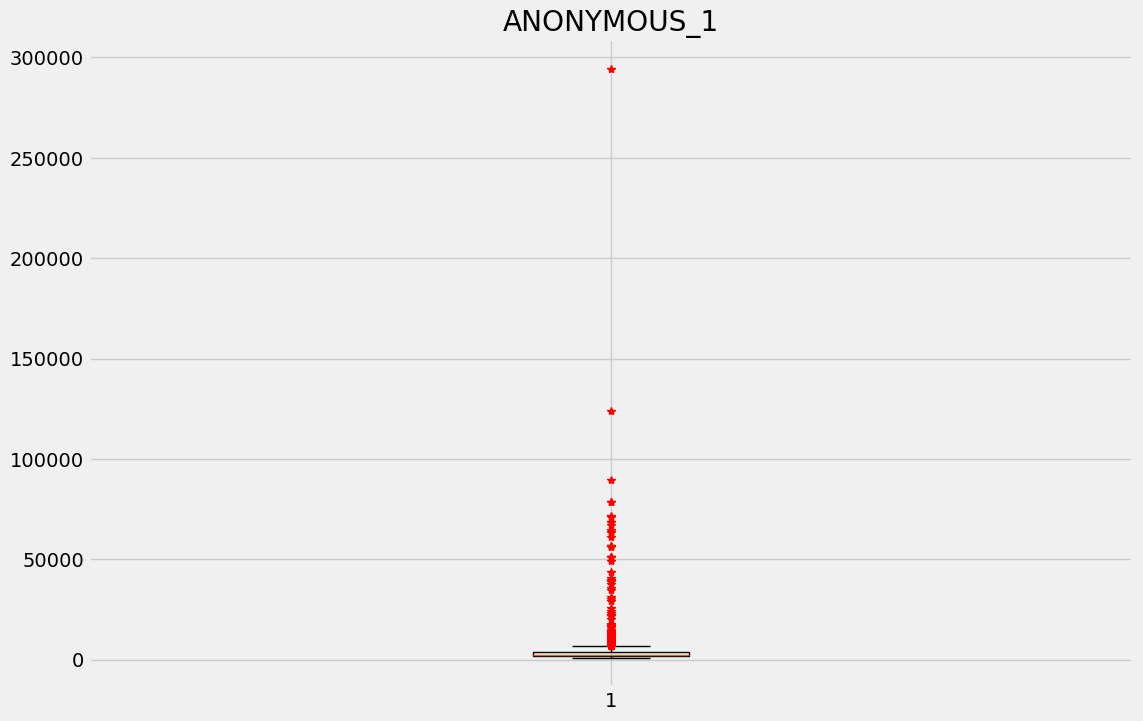

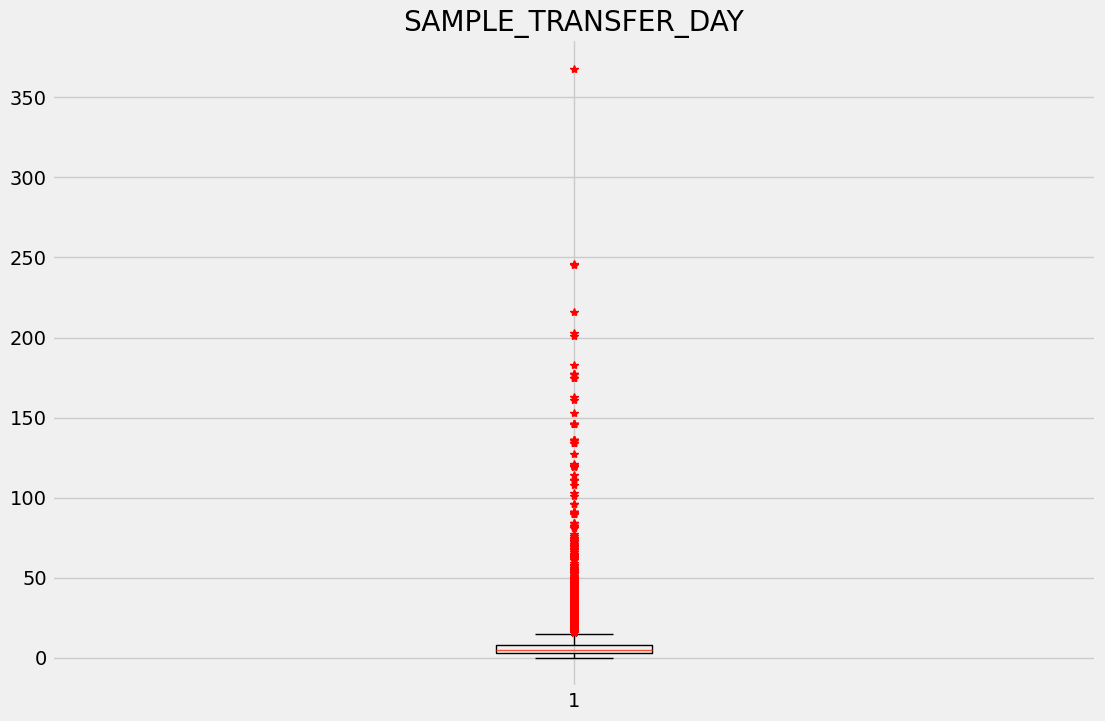

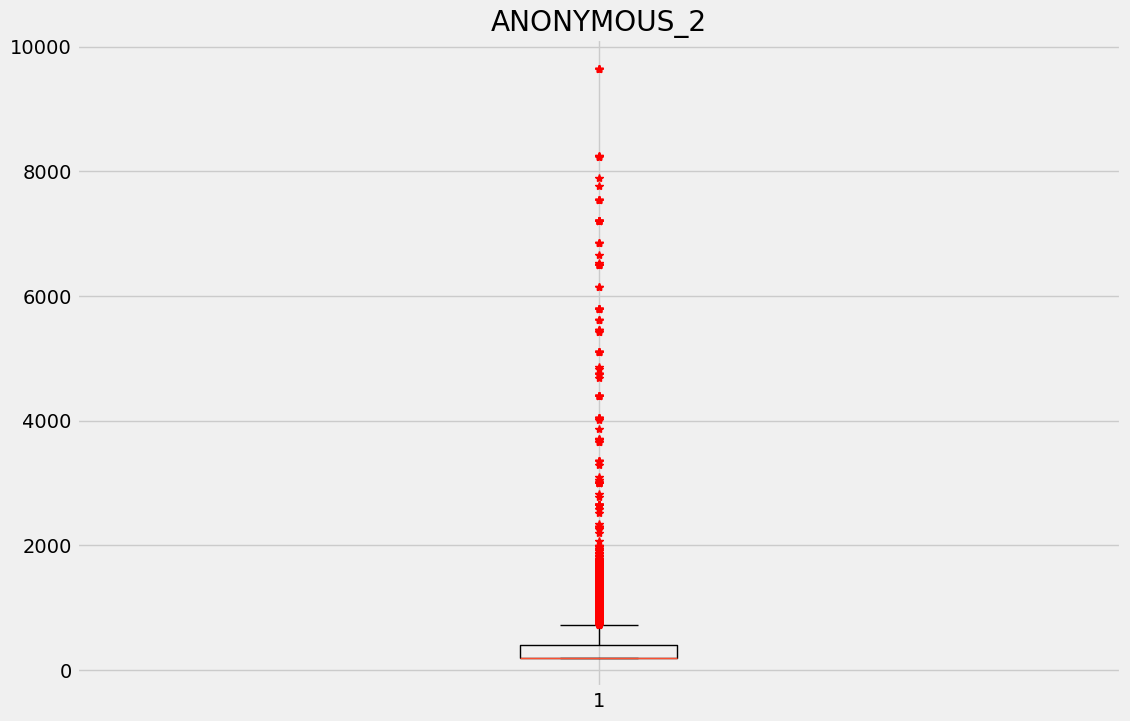

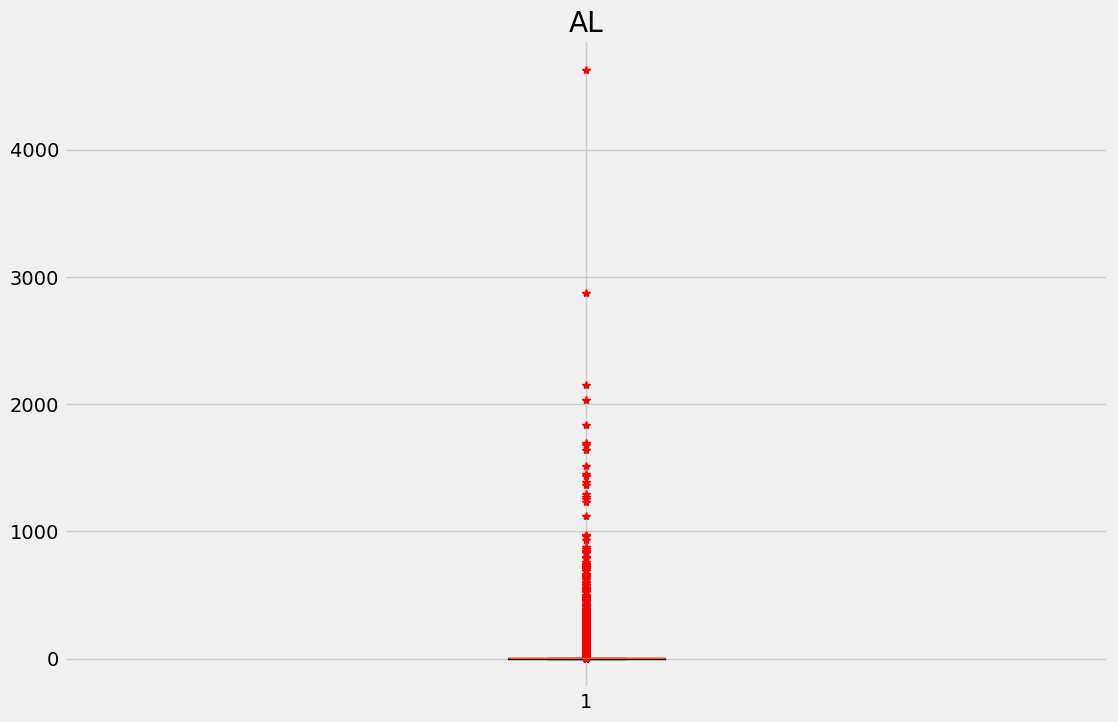

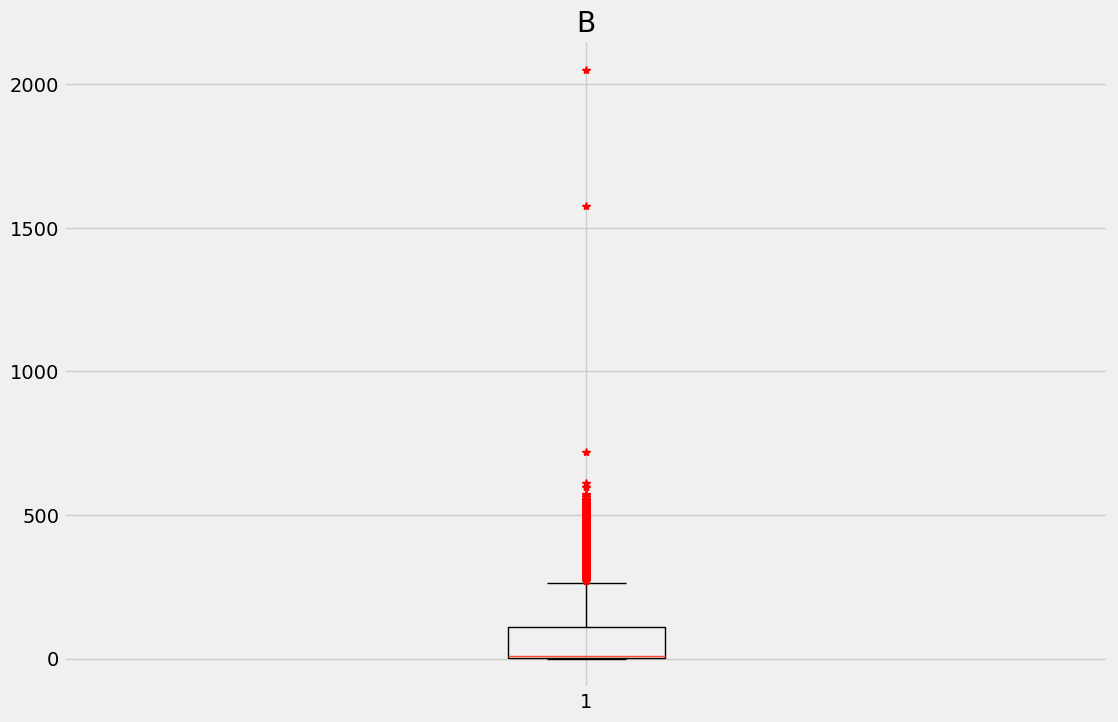

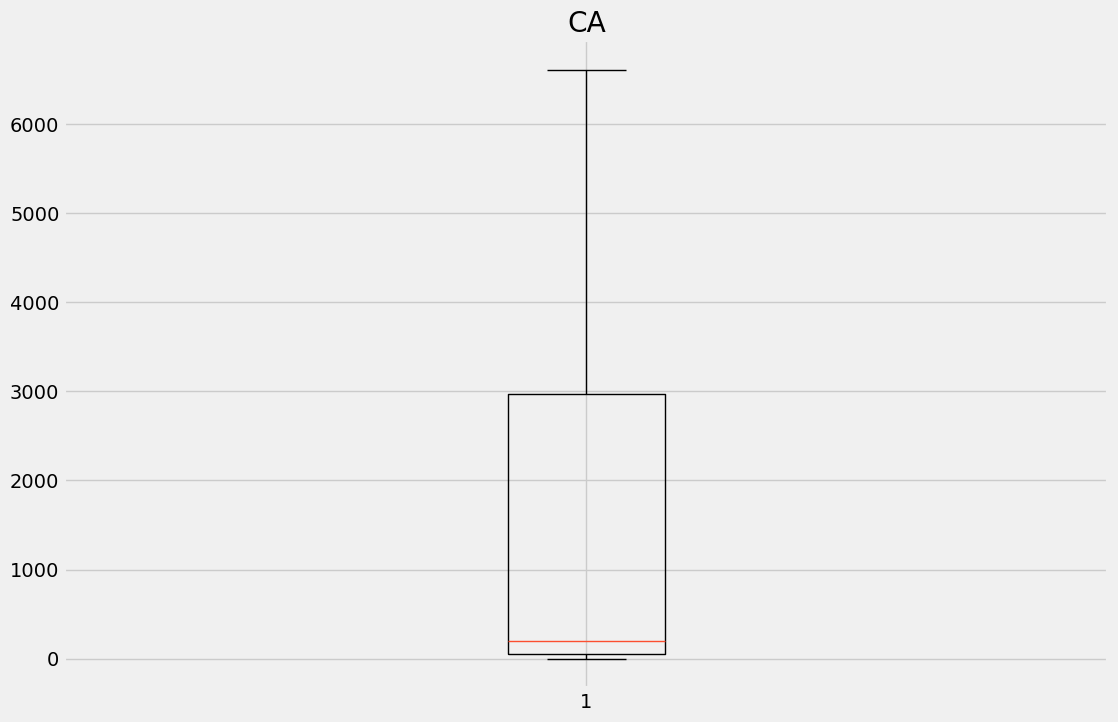

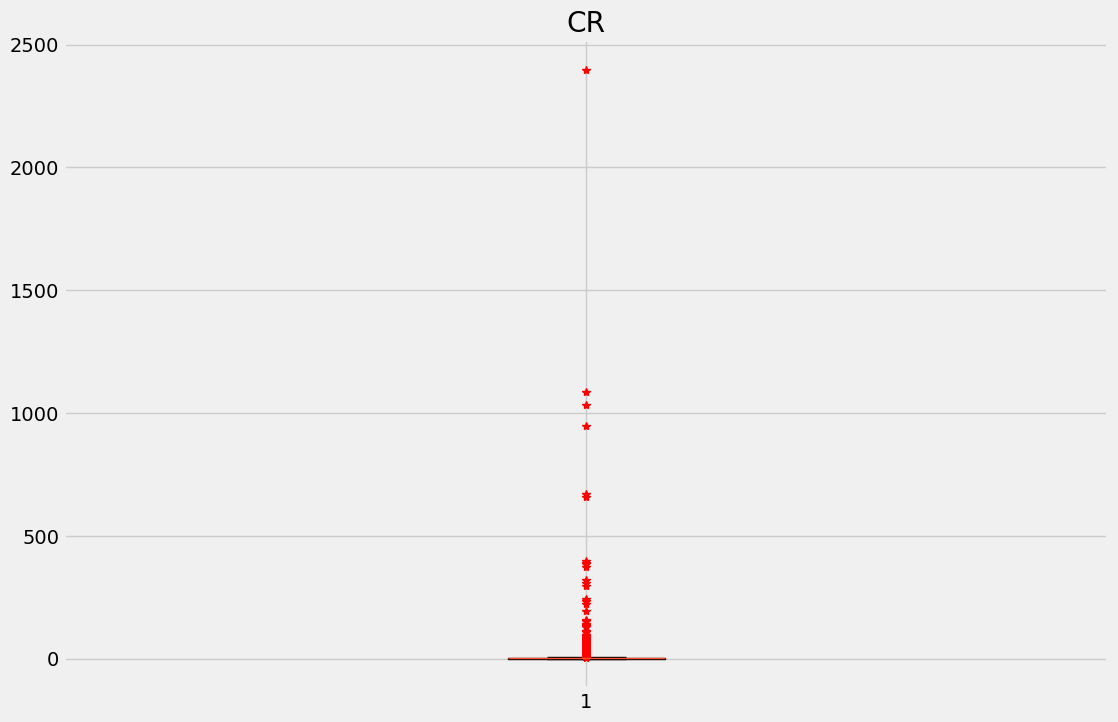

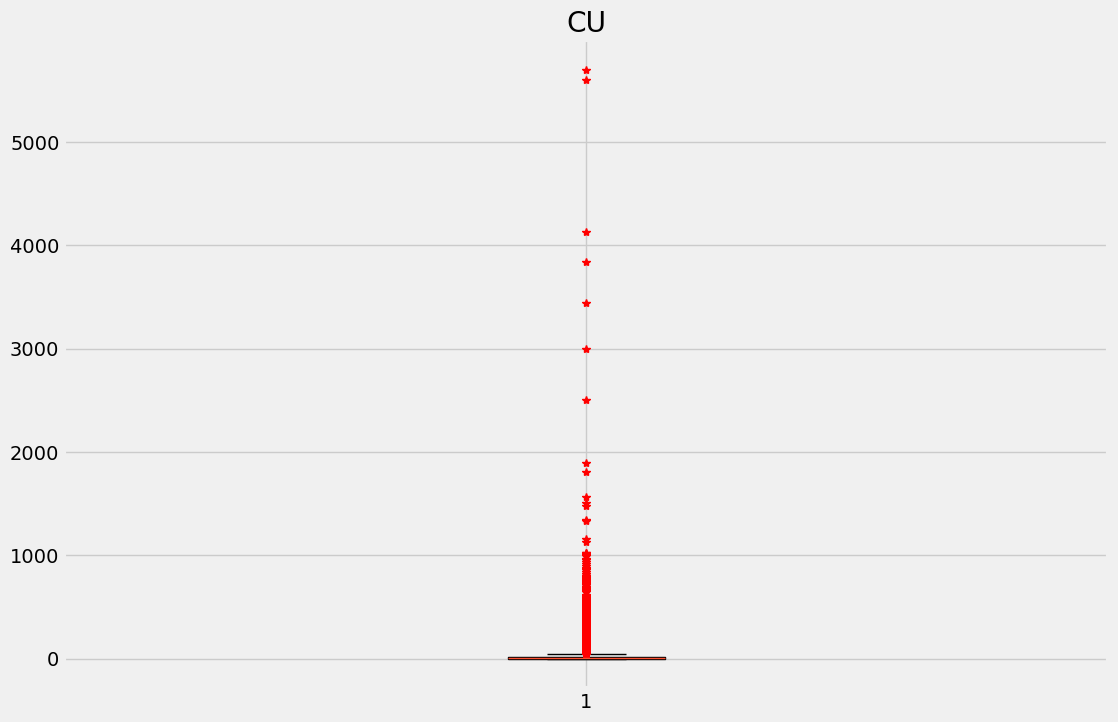

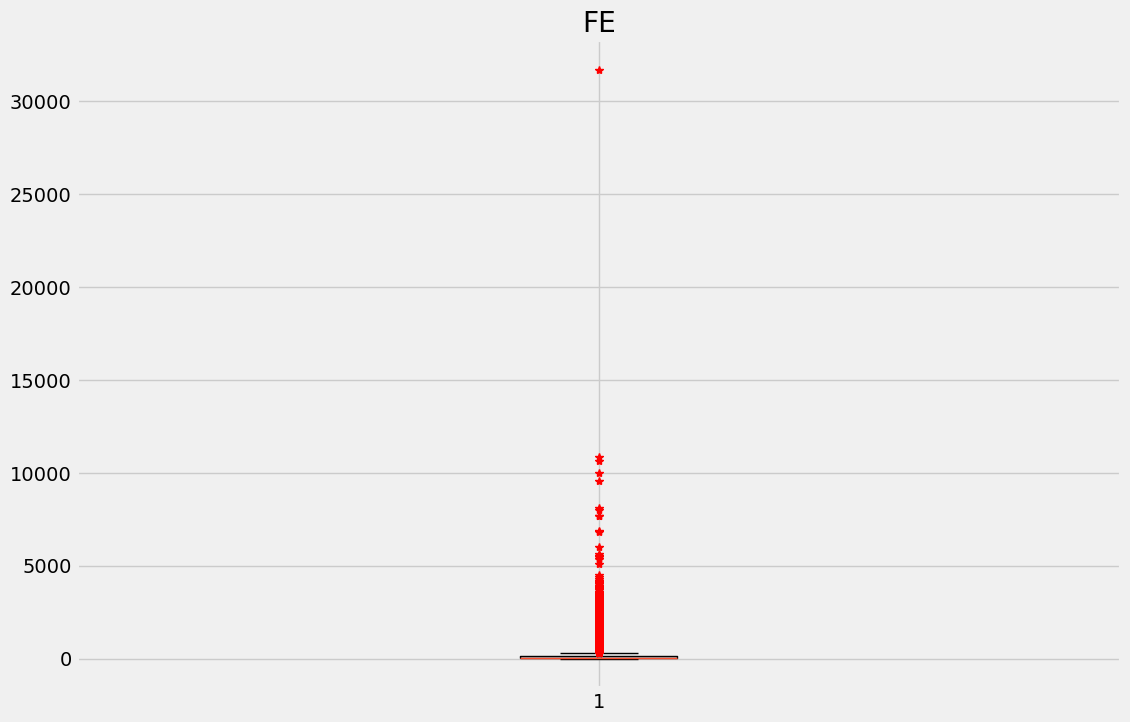

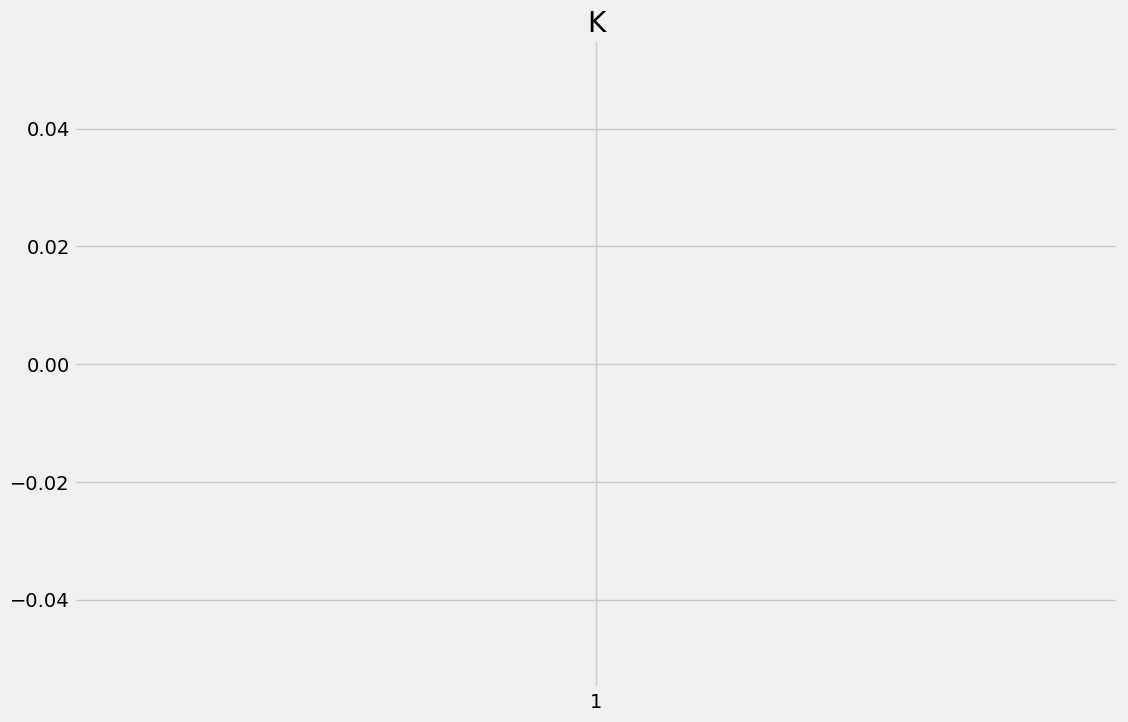

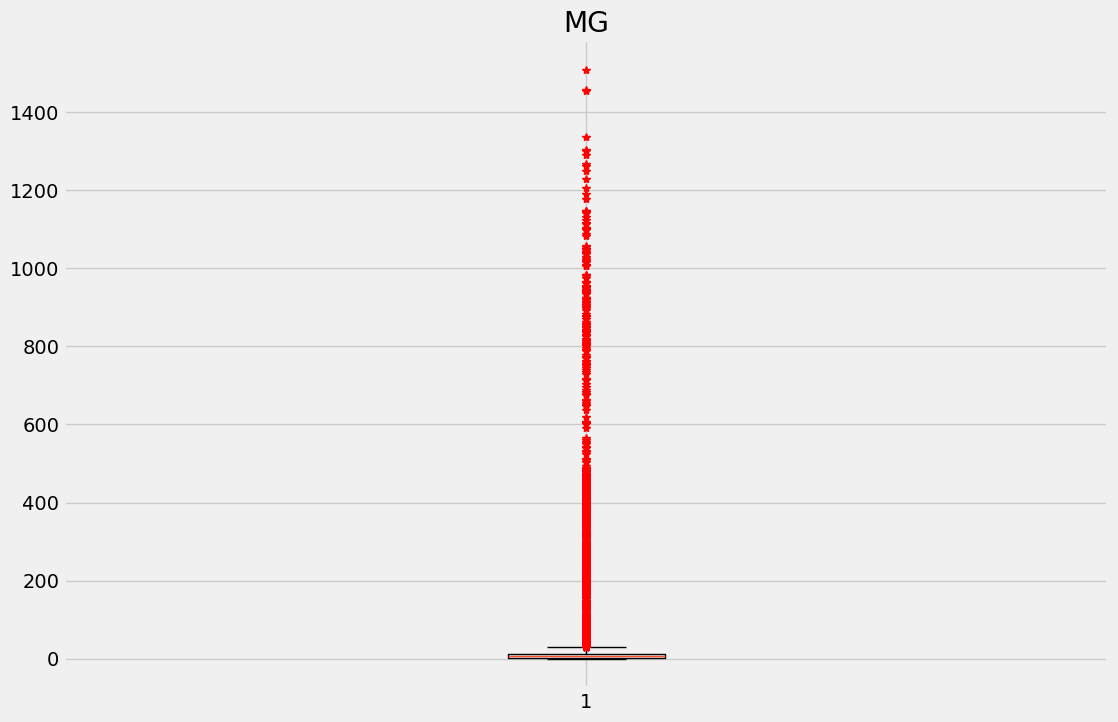

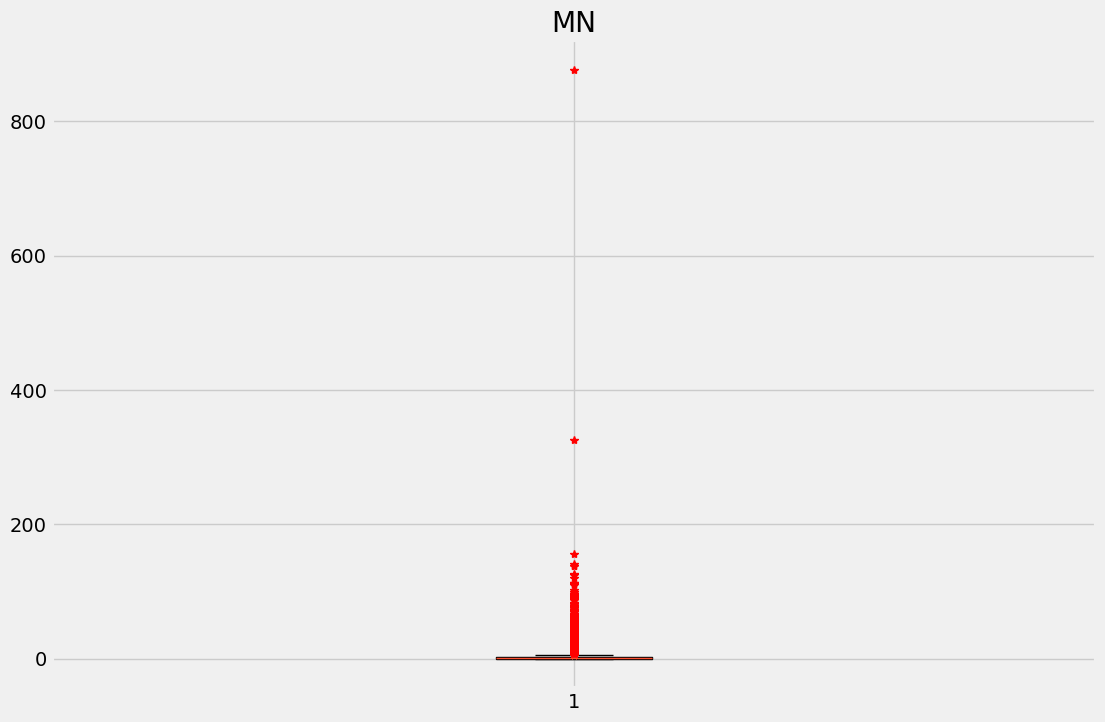

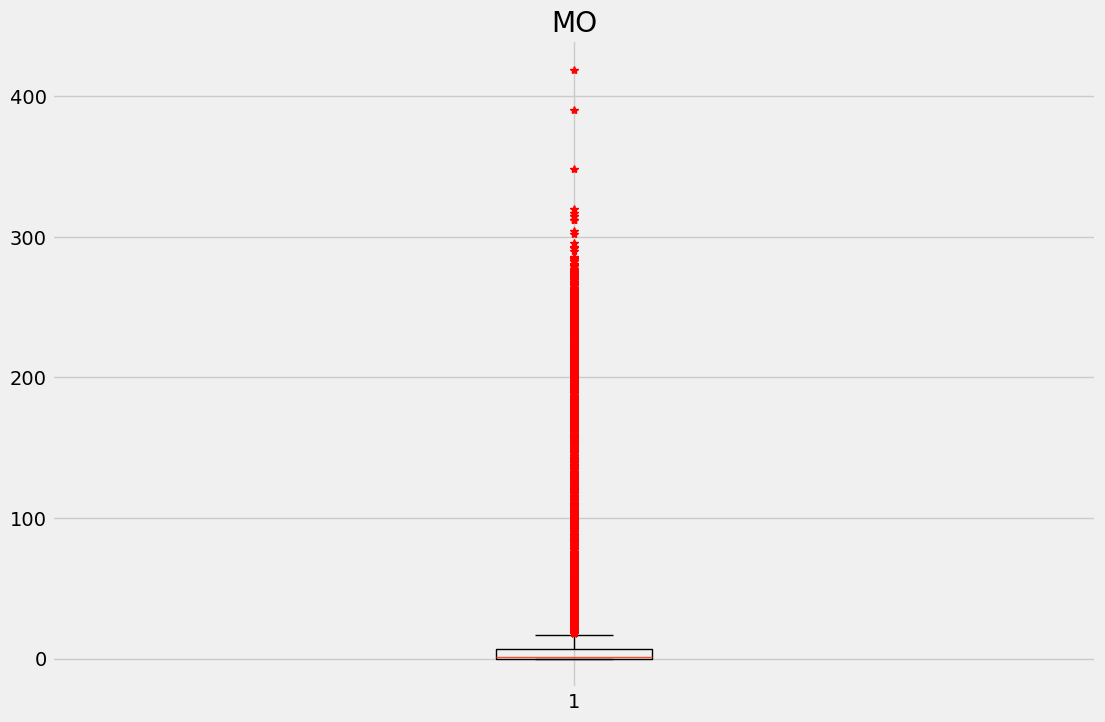

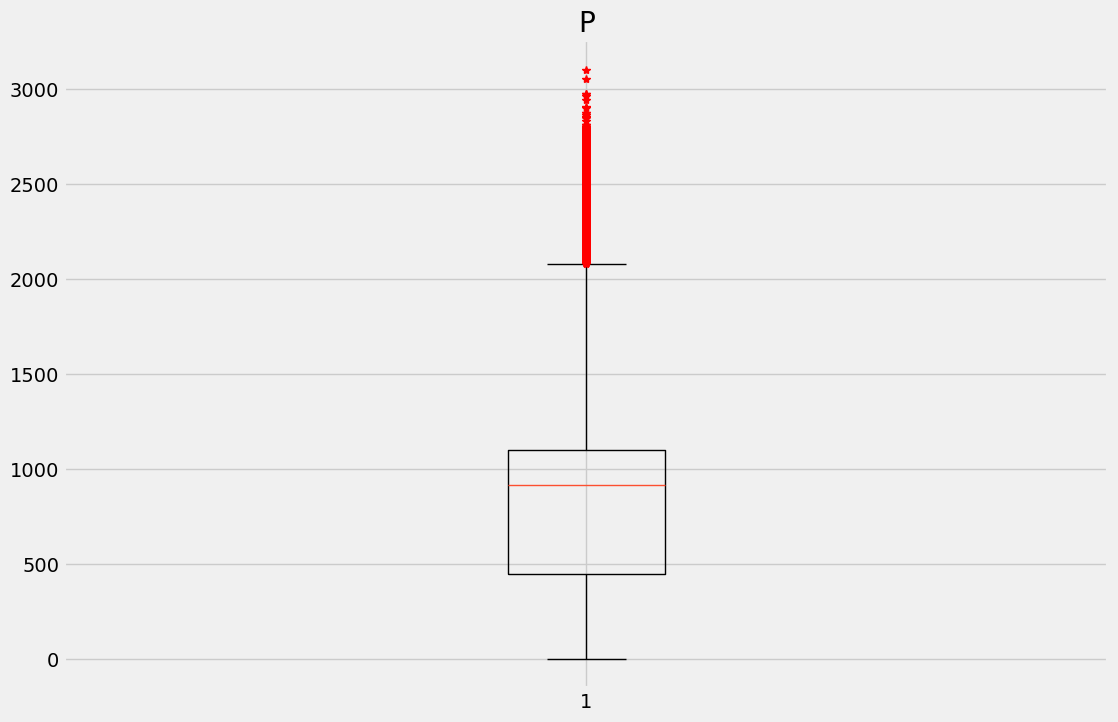

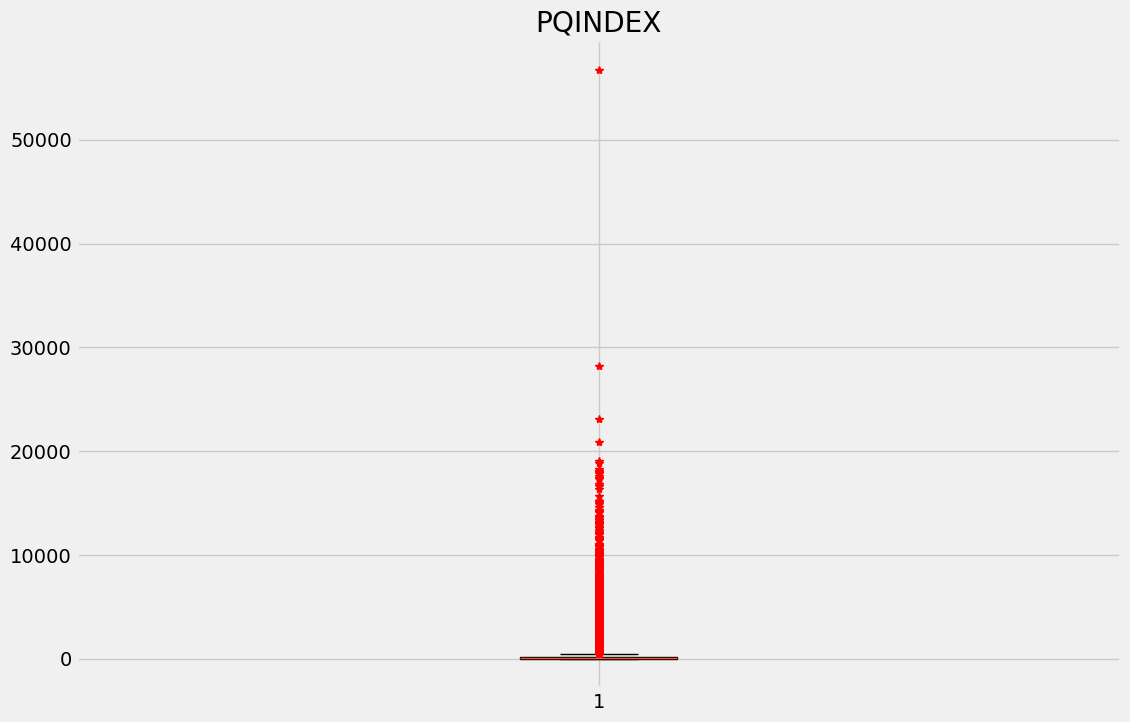

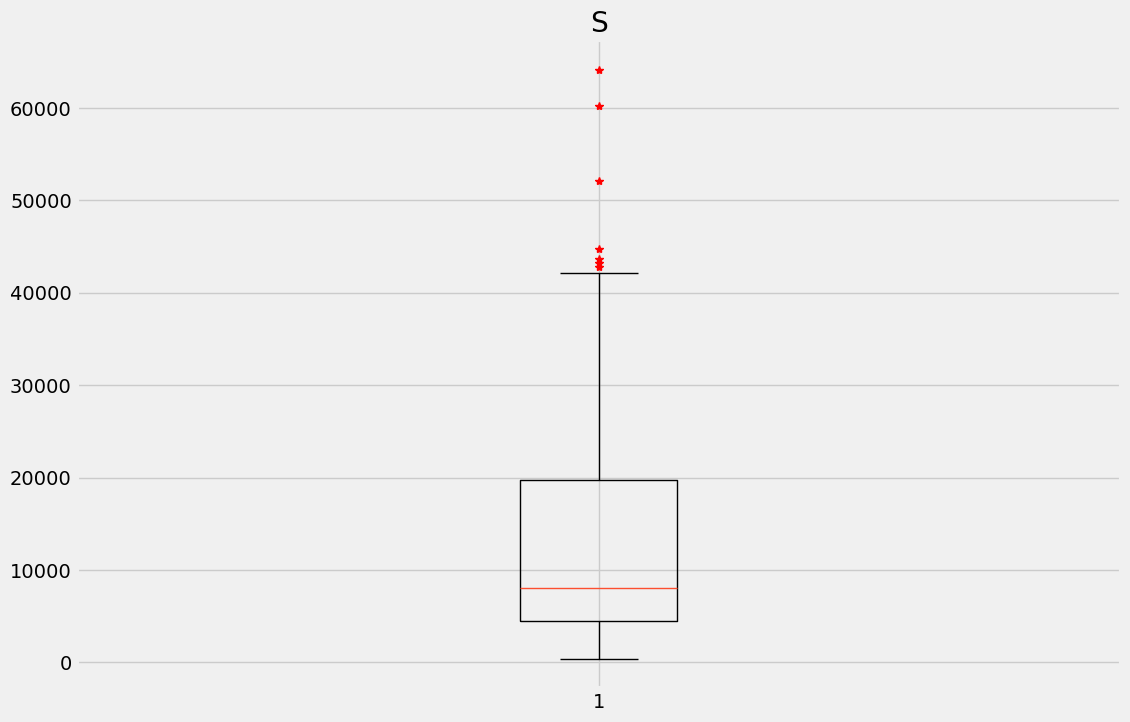

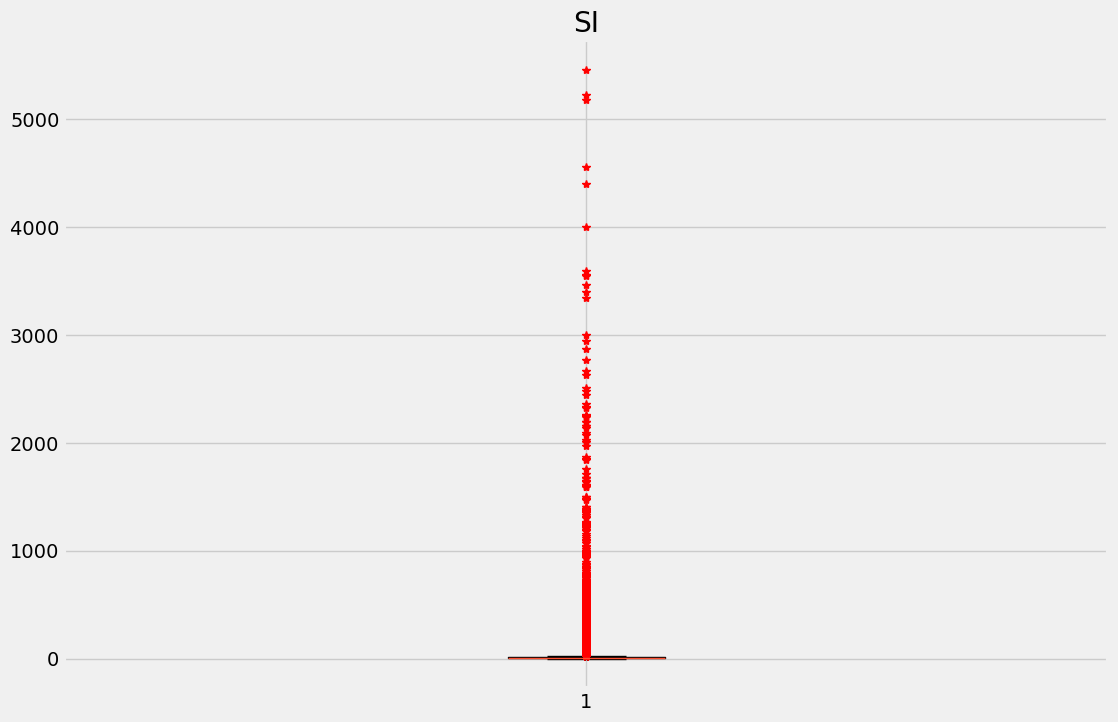

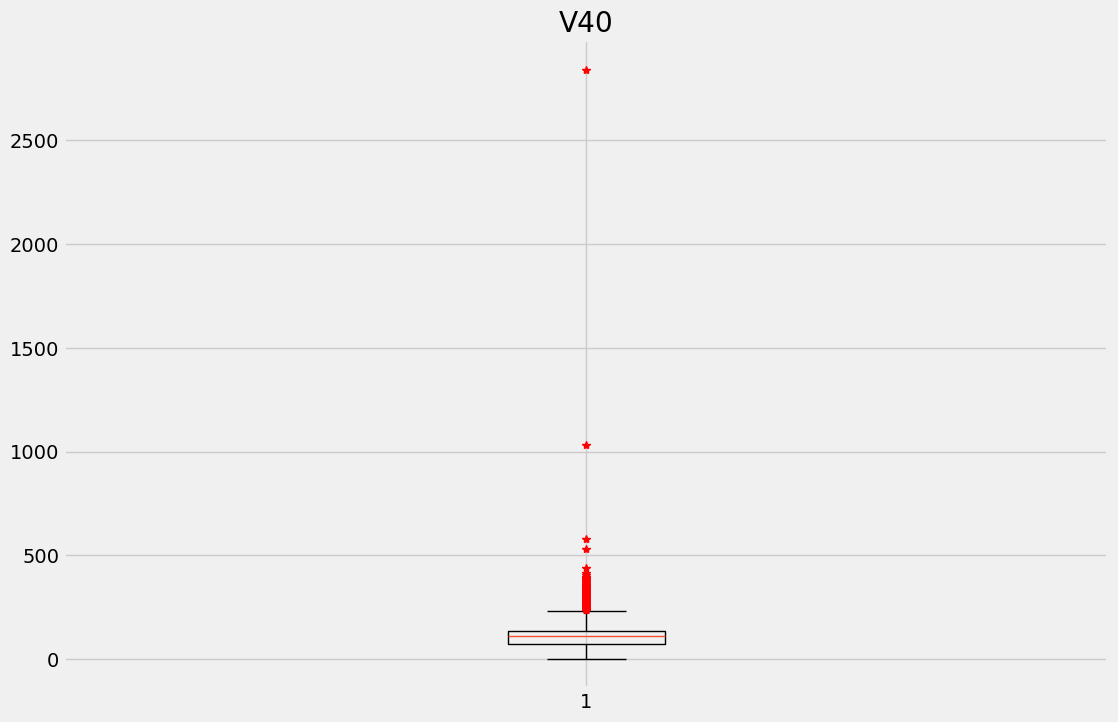

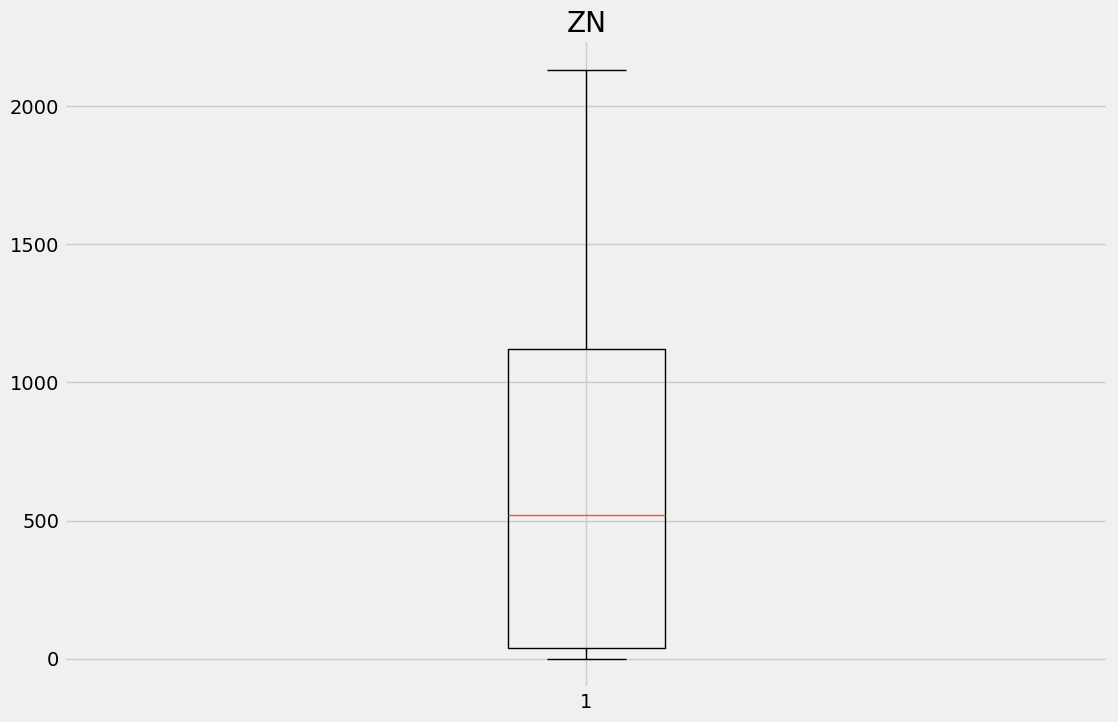

In [12]:
for col in numerical_features :
    plt.figure(figsize=(12, 8))
    plt.boxplot(train[col], sym='r*')
    plt.title(col)
    plt.show()

**Visualization numerical features - Test**

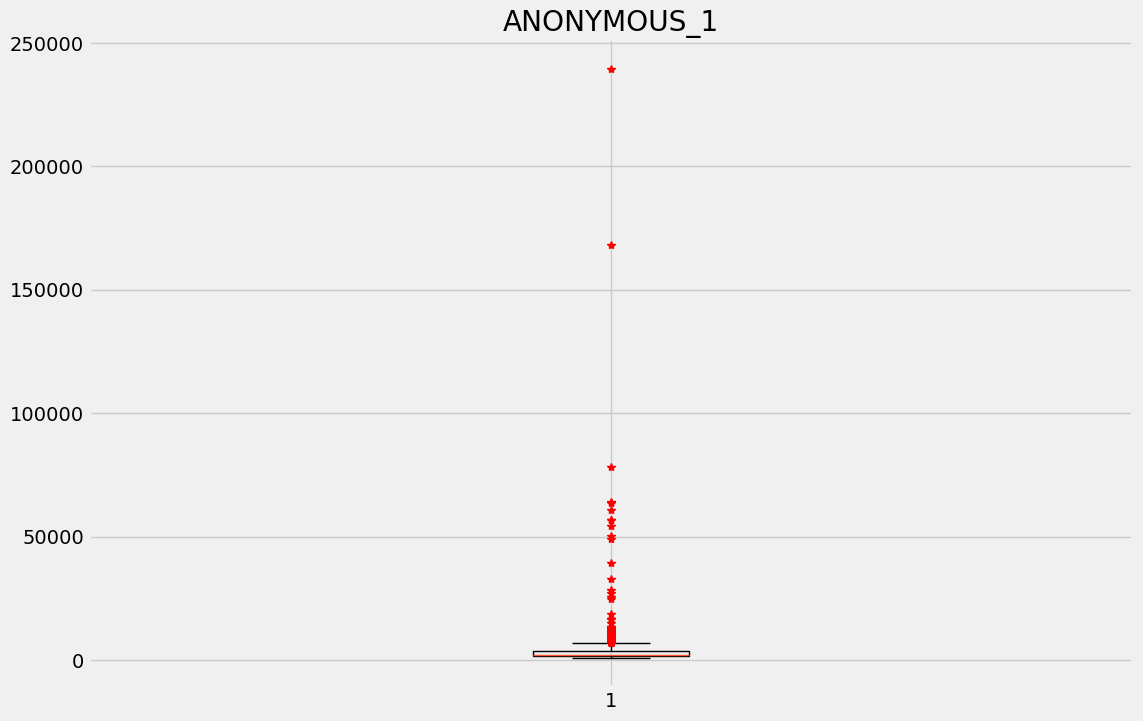

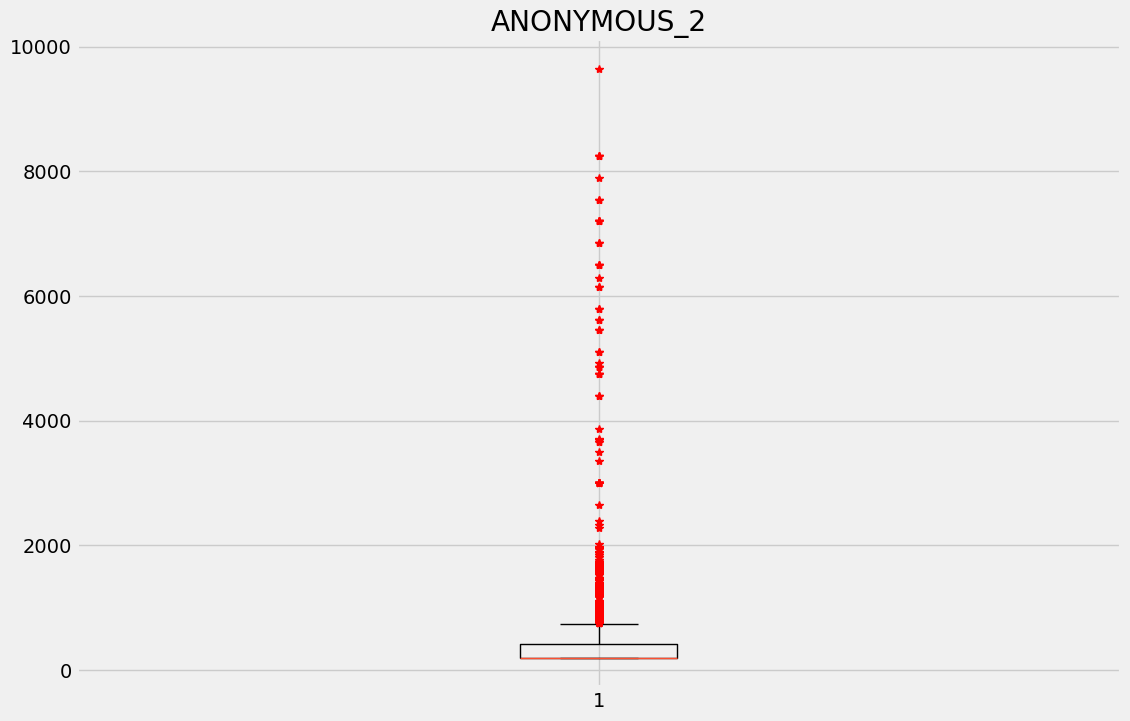

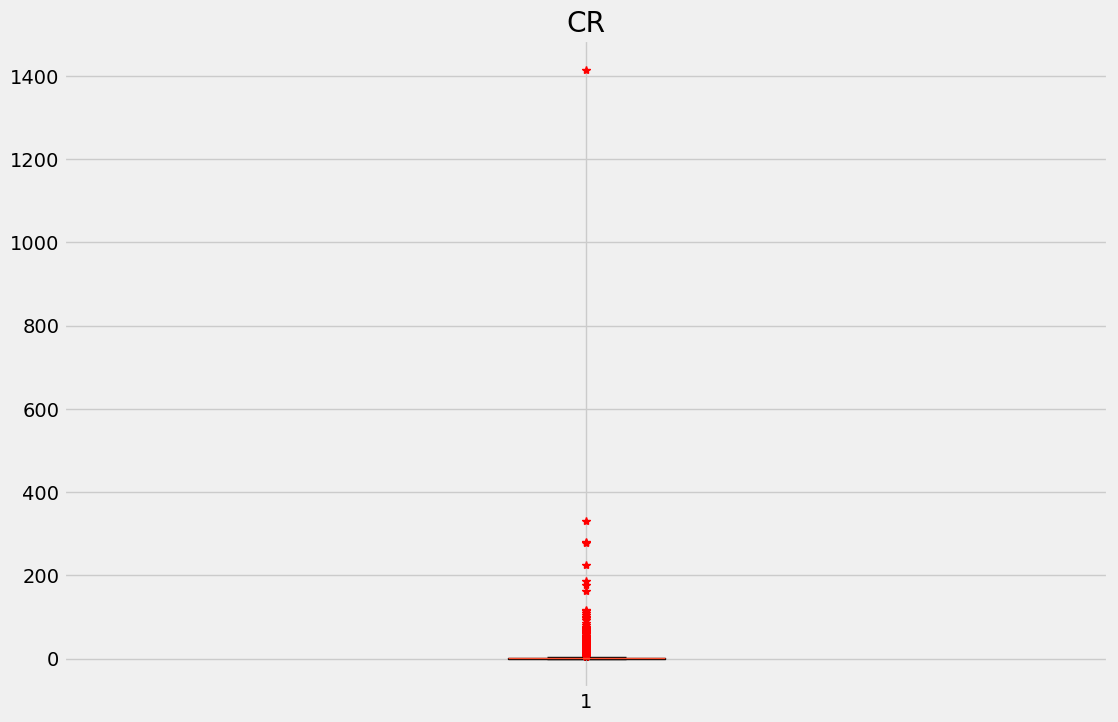

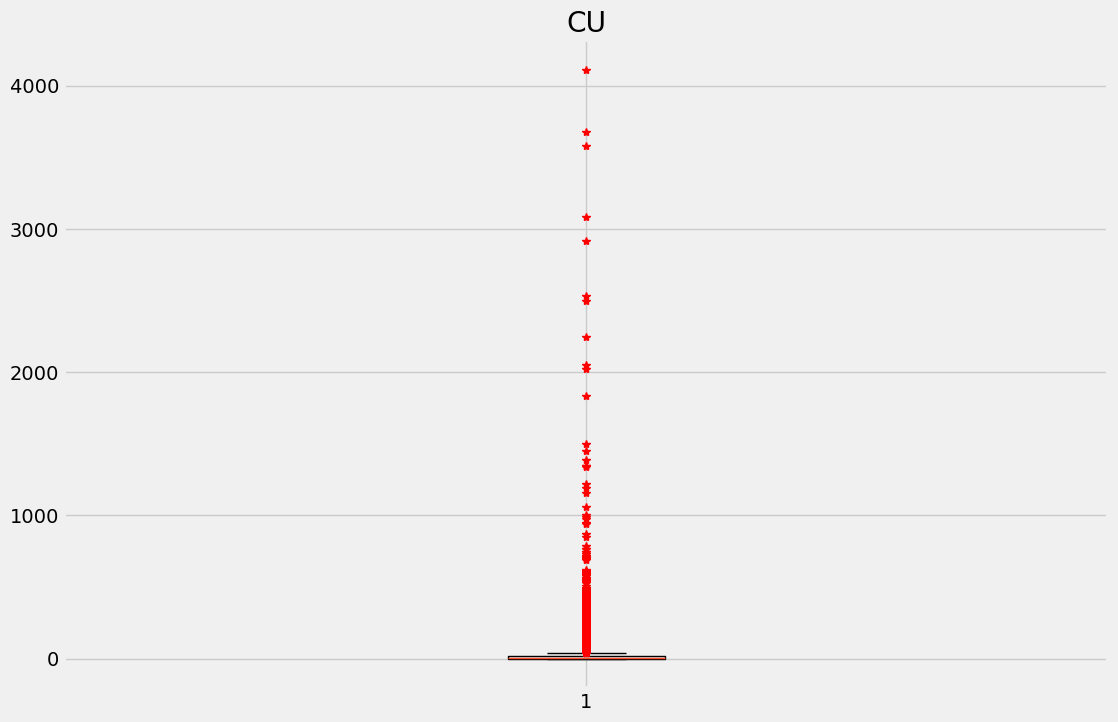

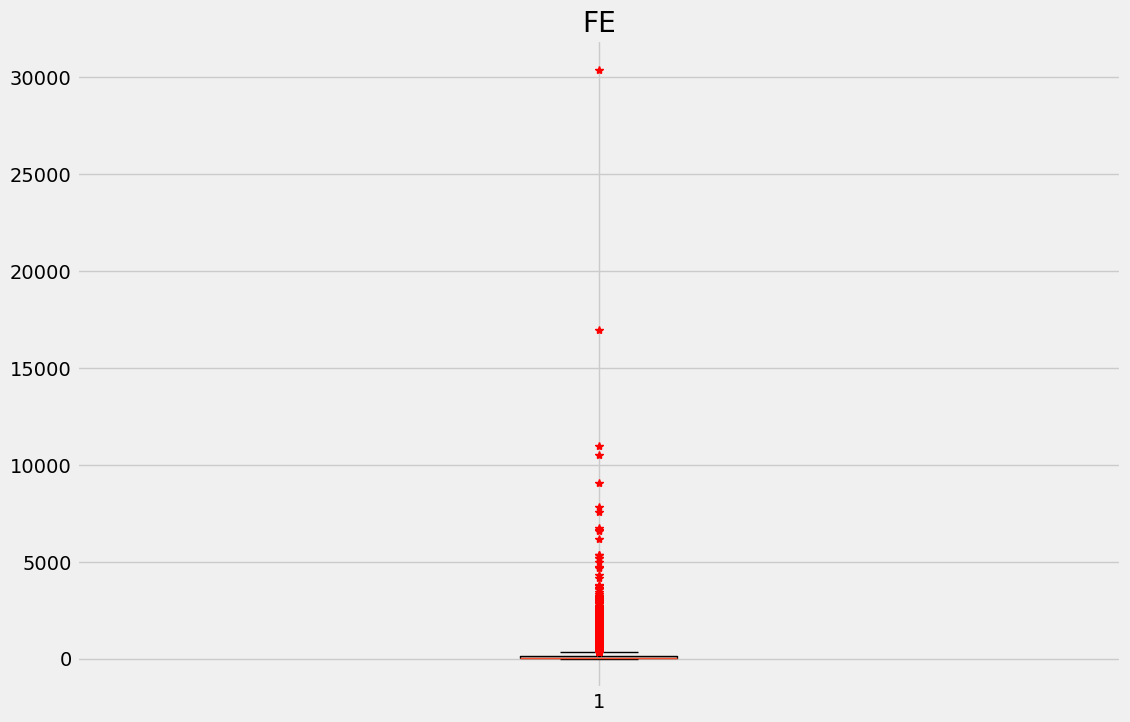

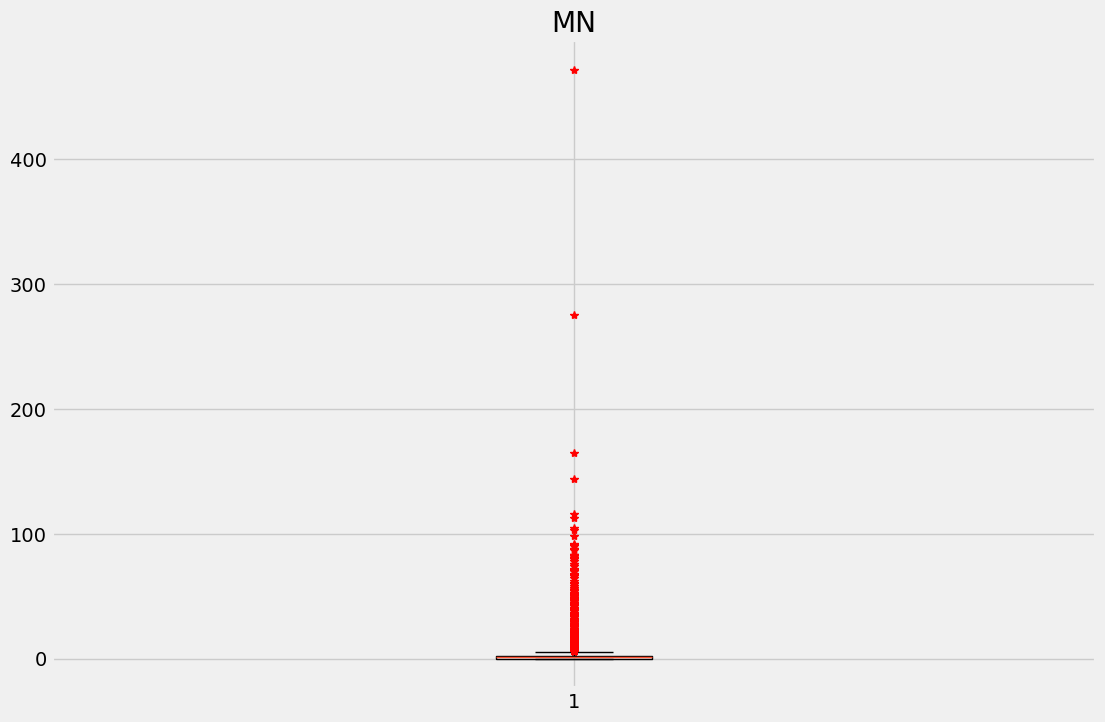

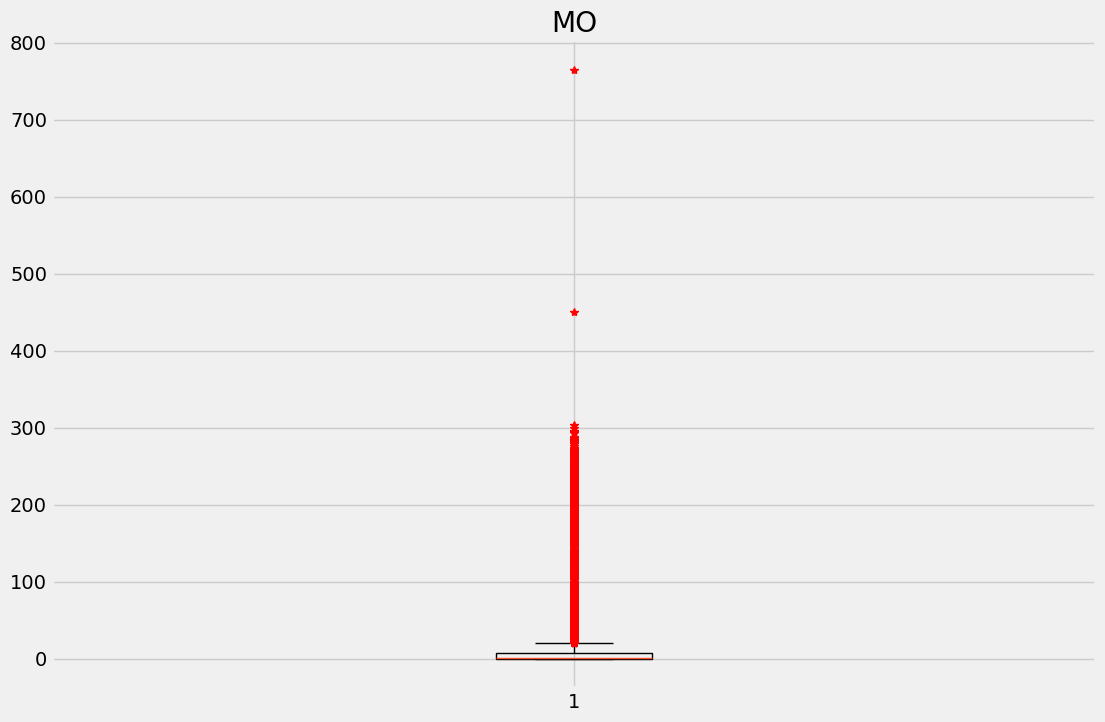

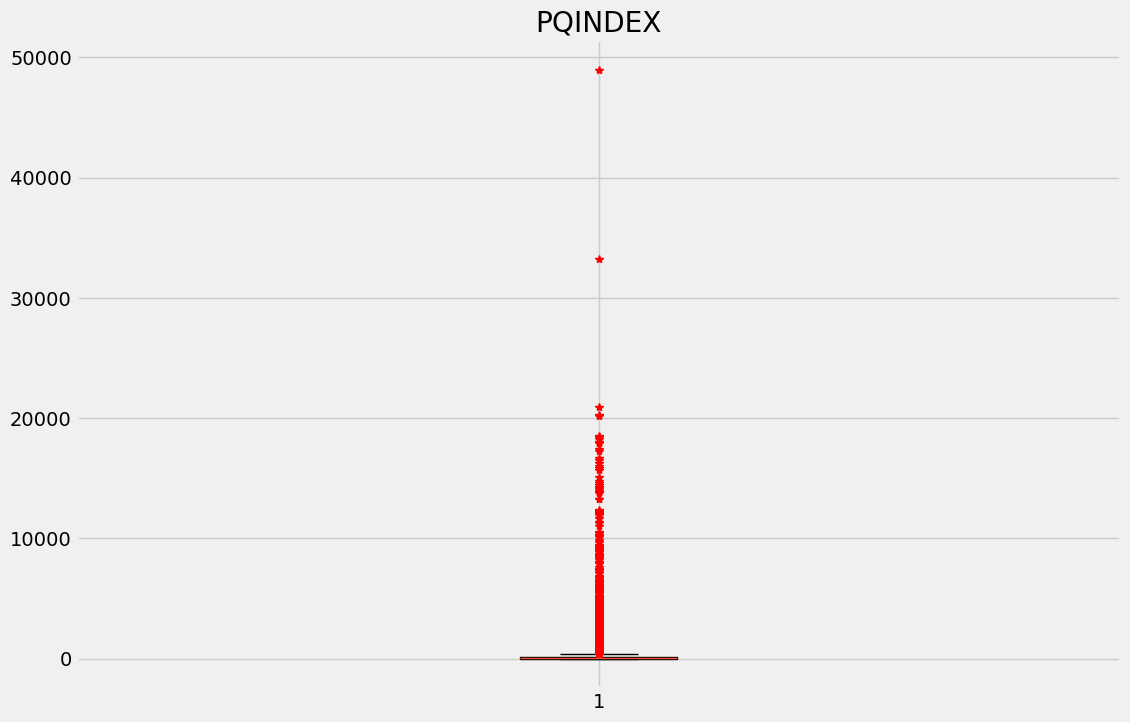

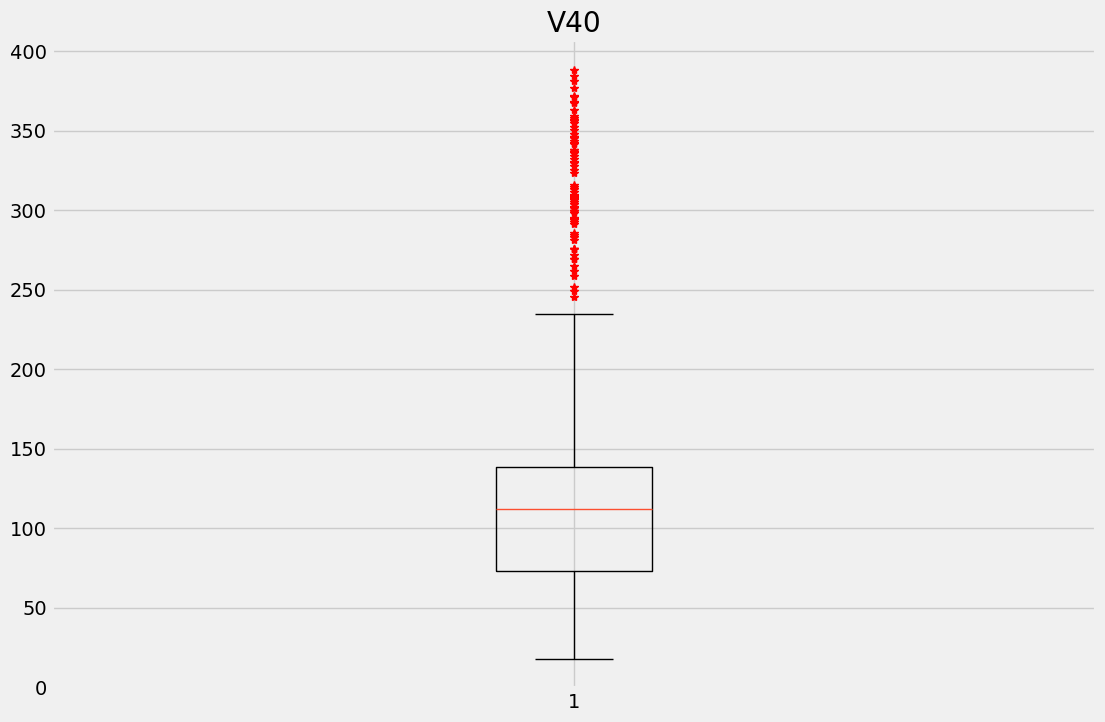

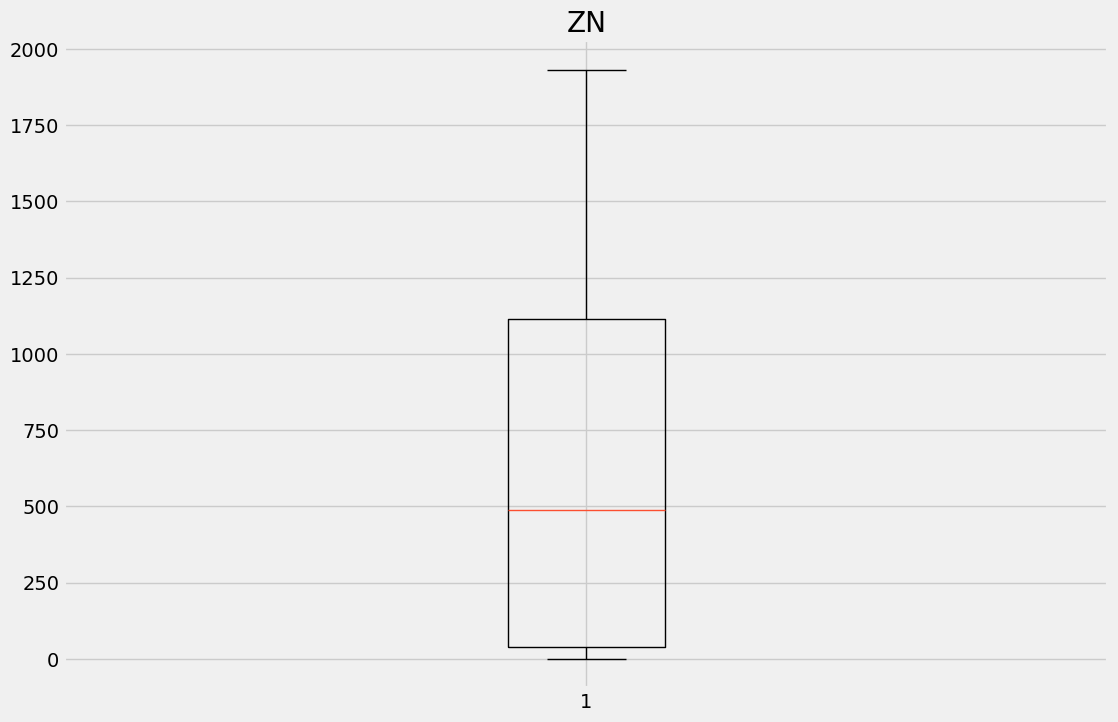

In [13]:
for col in test_numerical_features :
    plt.figure(figsize=(12, 8))
    plt.boxplot(test[col], sym='r*')
    plt.title(col)
    plt.show()

**Change numerical outlier -> Median**

In [14]:
for col in numerical_features :
    if col in ['SI', 'PQINDEX', 'MO', 'K', 'FE', 'CU']:
        over_outliers = np.percentile(train[col], 75)
        under_outliers = np.percentile(train[col], 25)
    else:
        over_outliers = np.percentile(train[col], 90)
        under_outliers = np.percentile(train[col], 10)
    
    train.loc[train[col] >= over_outliers, col] = over_outliers
    train.loc[train[col] <= under_outliers, col] = under_outliers
    train[col].fillna(train[col].median(), inplace=True)
    
    min_max_scaler.fit(train[col].values.reshape(-1, 1))
    train[col] = min_max_scaler.transform(train[col].values.reshape(-1, 1))
    
    if col in test.columns:
        test.loc[test[col] >= over_outliers, col] = over_outliers
        test.loc[test[col] <= under_outliers, col] = under_outliers
        test[col].fillna(train[col].median(), inplace=True)
        test[col] = min_max_scaler.transform(test[col].values.reshape(-1, 1))

**Visualization numerical features - Train**

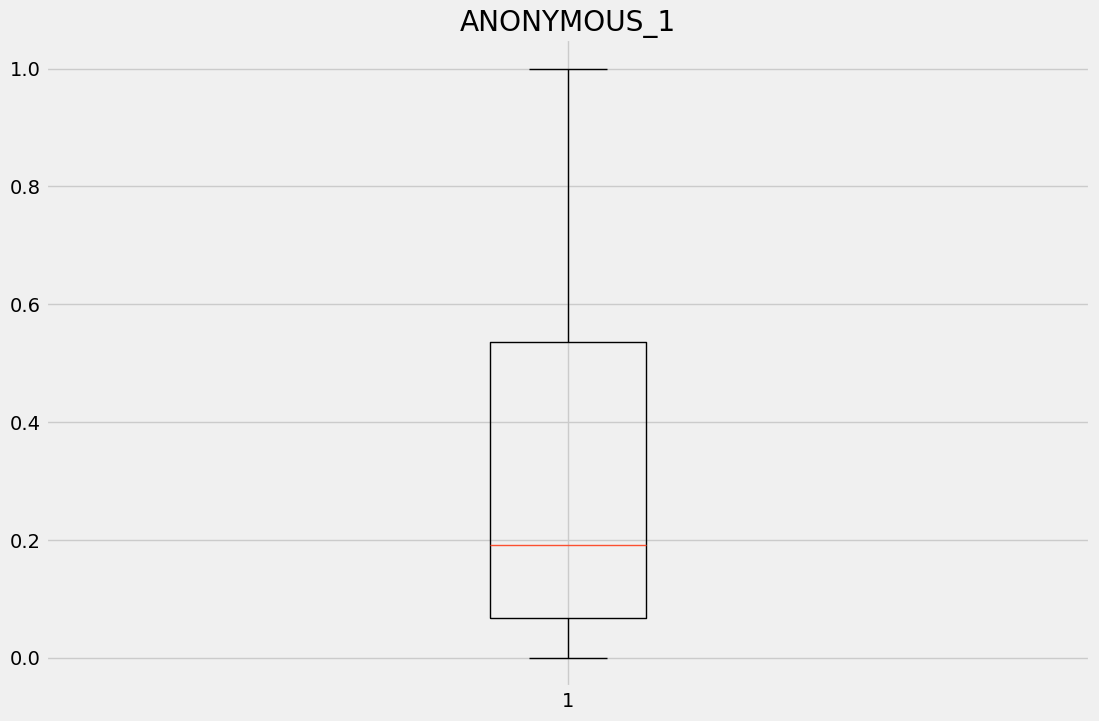

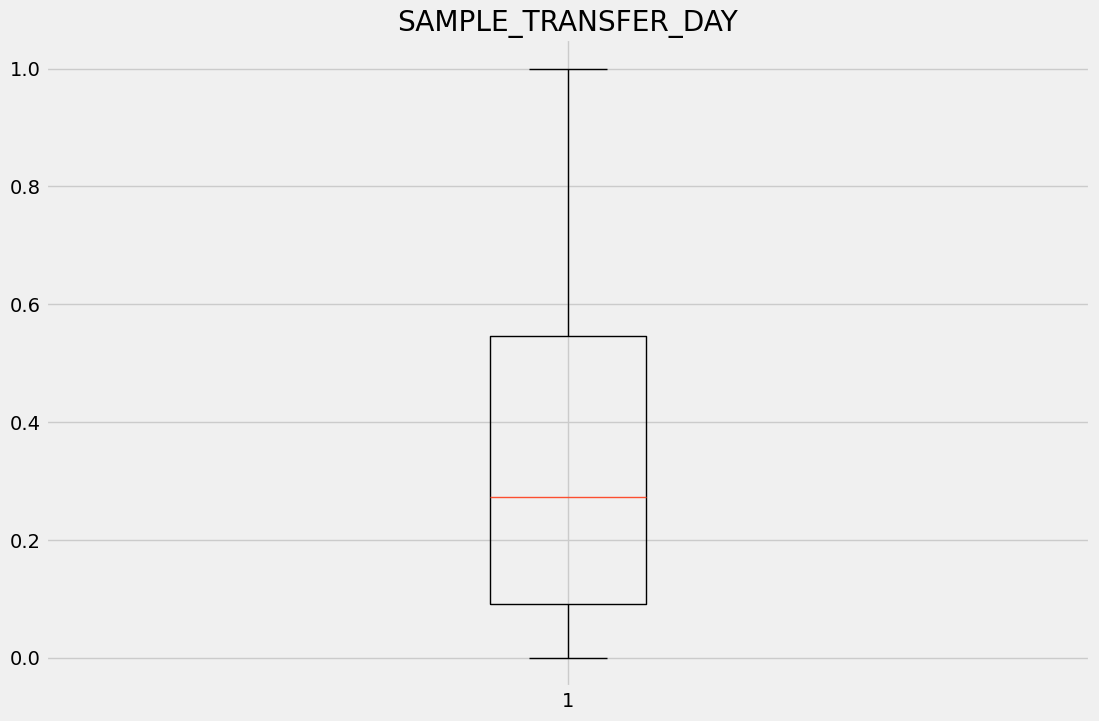

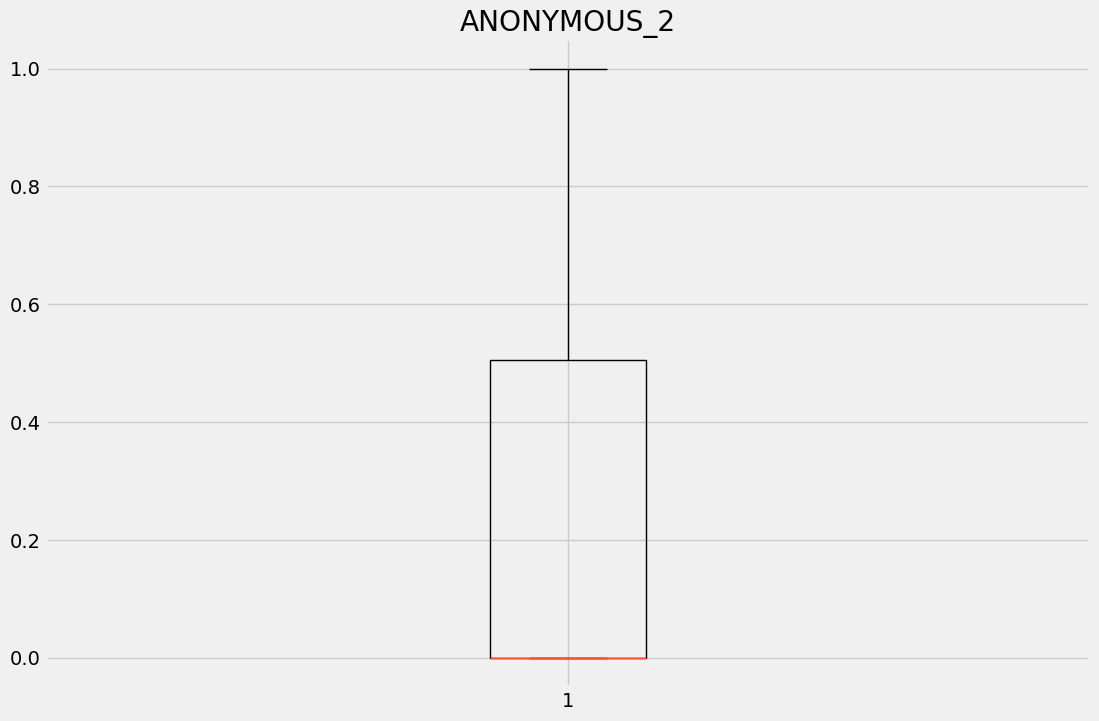

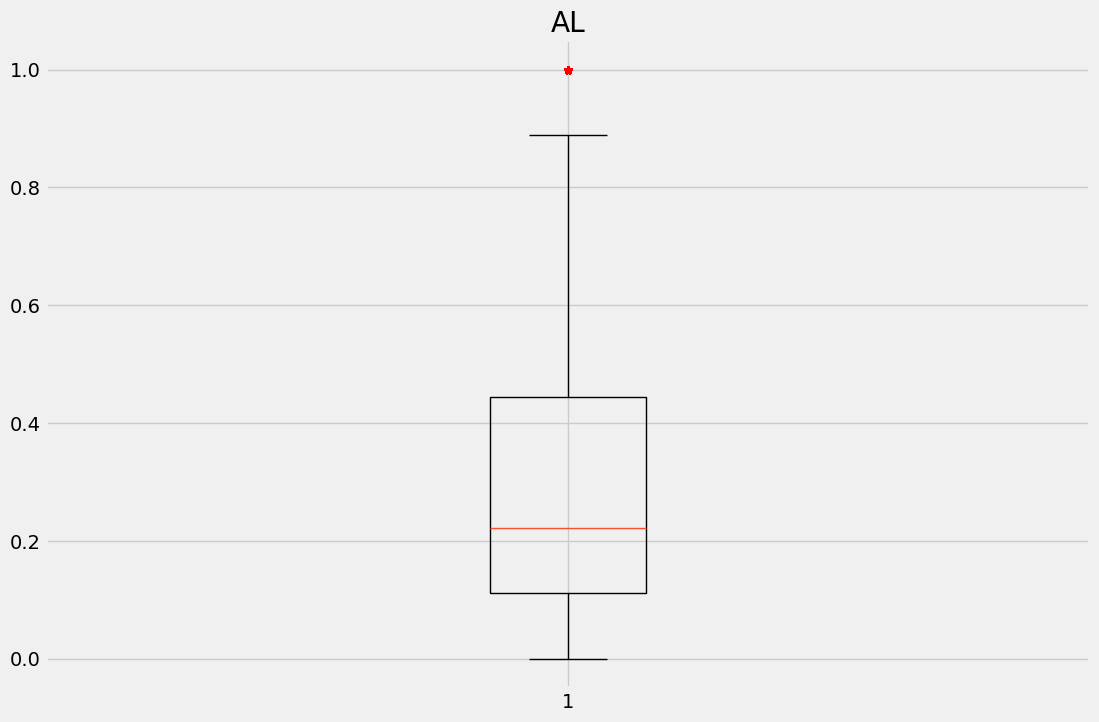

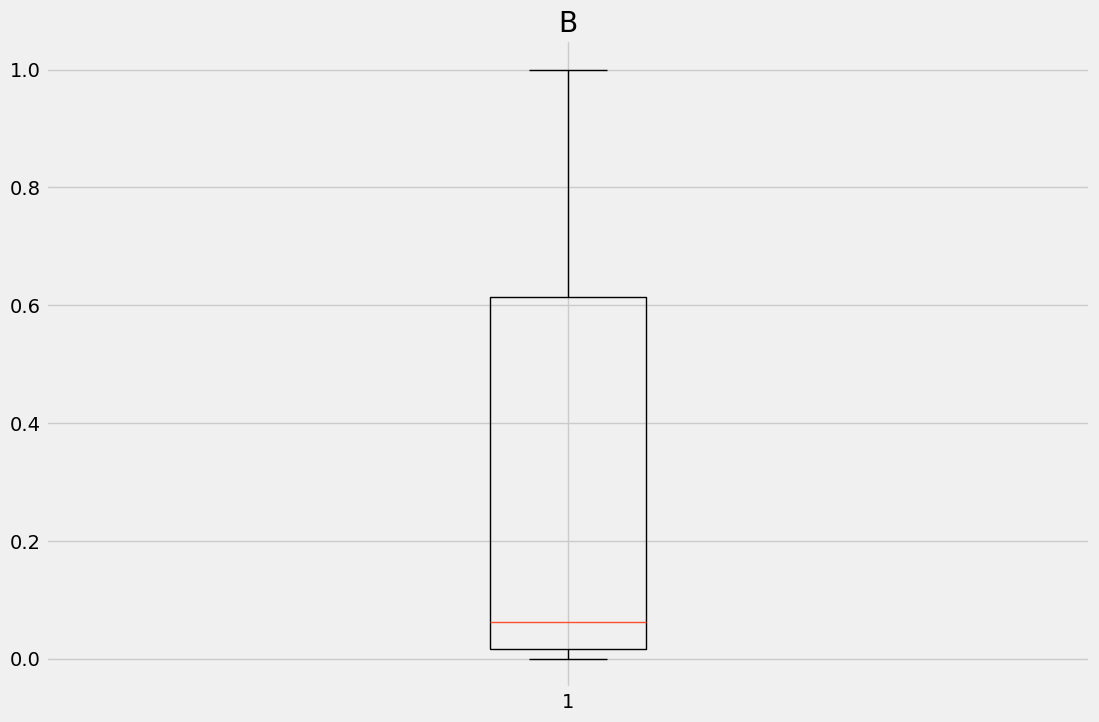

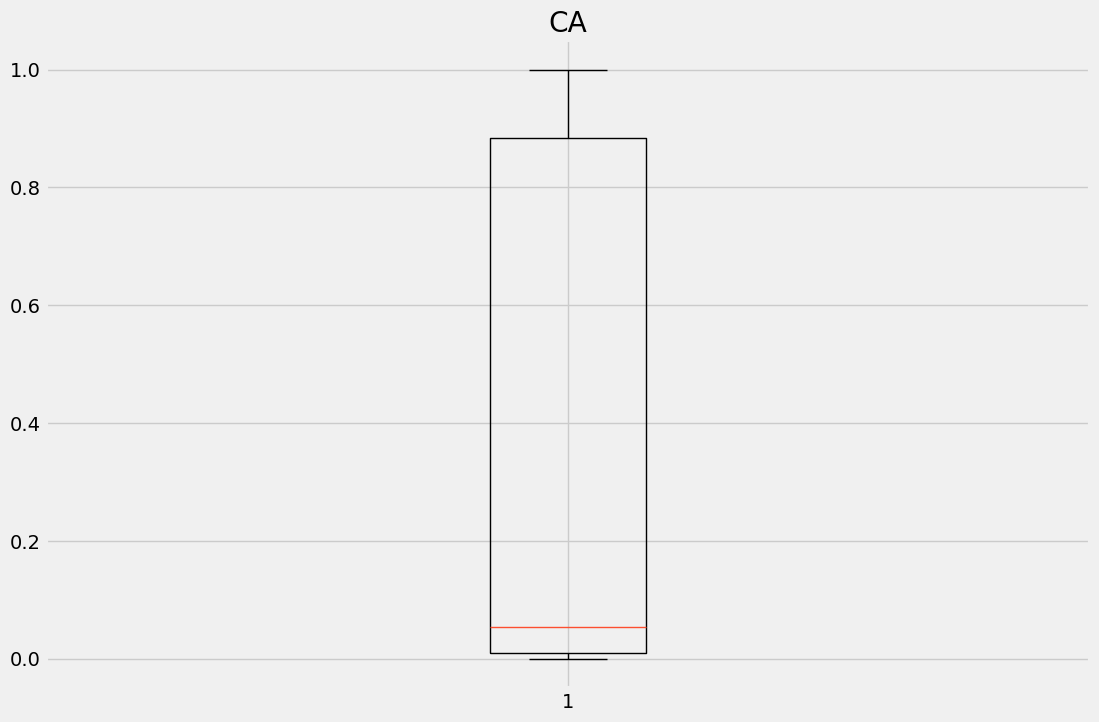

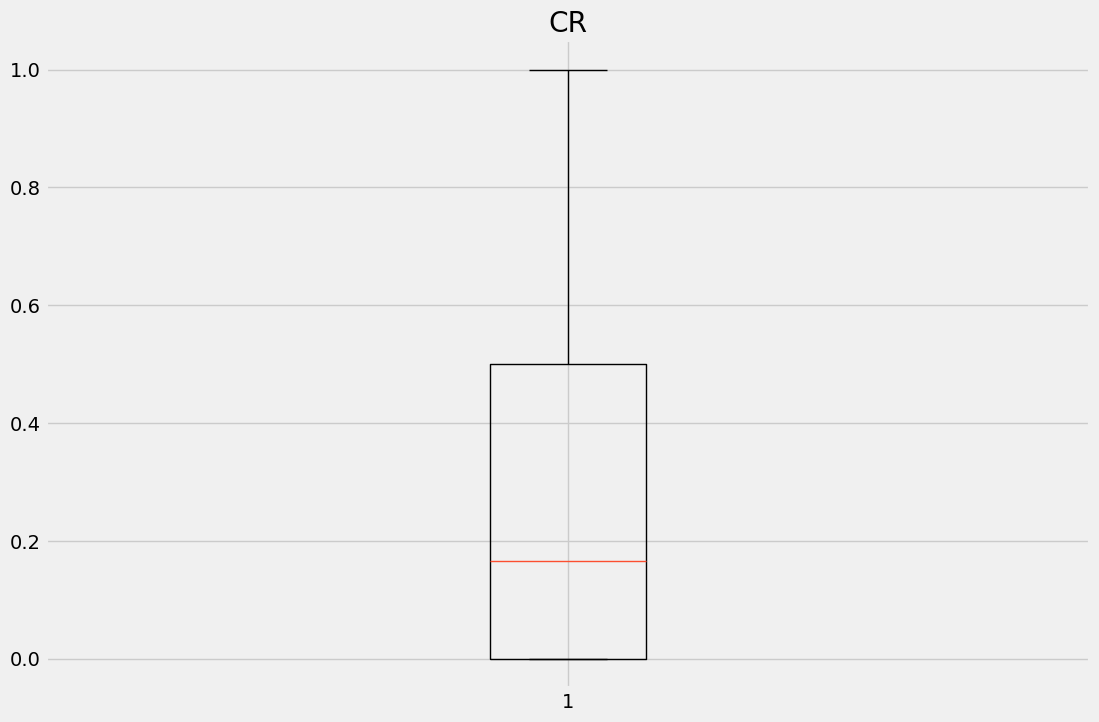

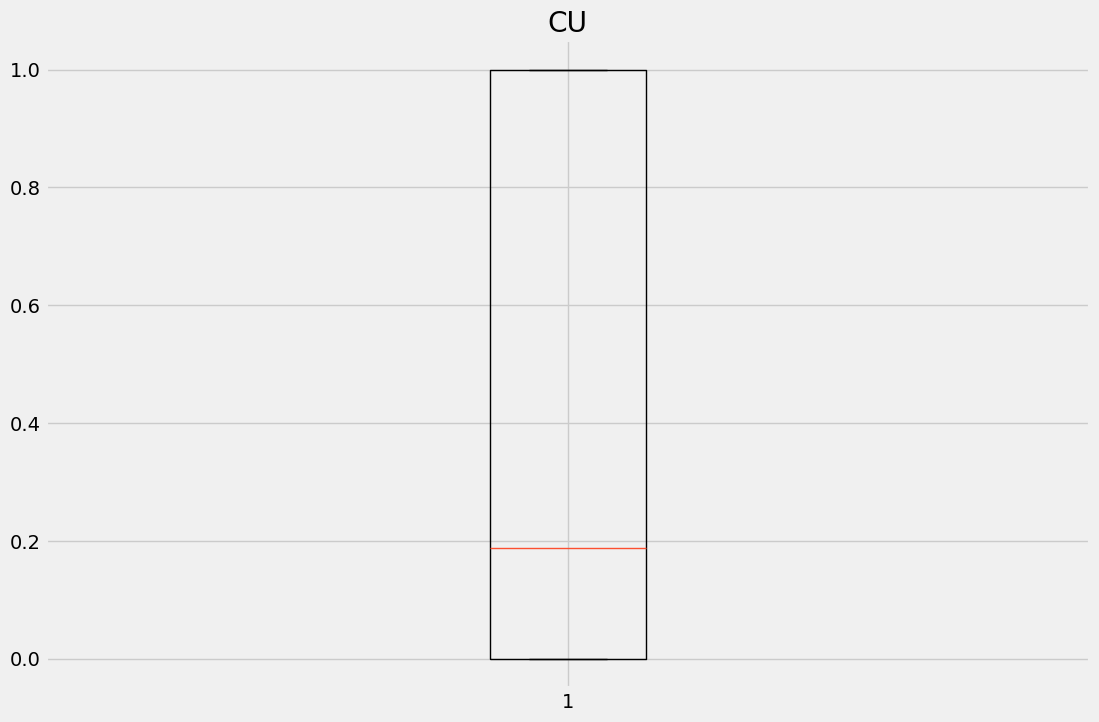

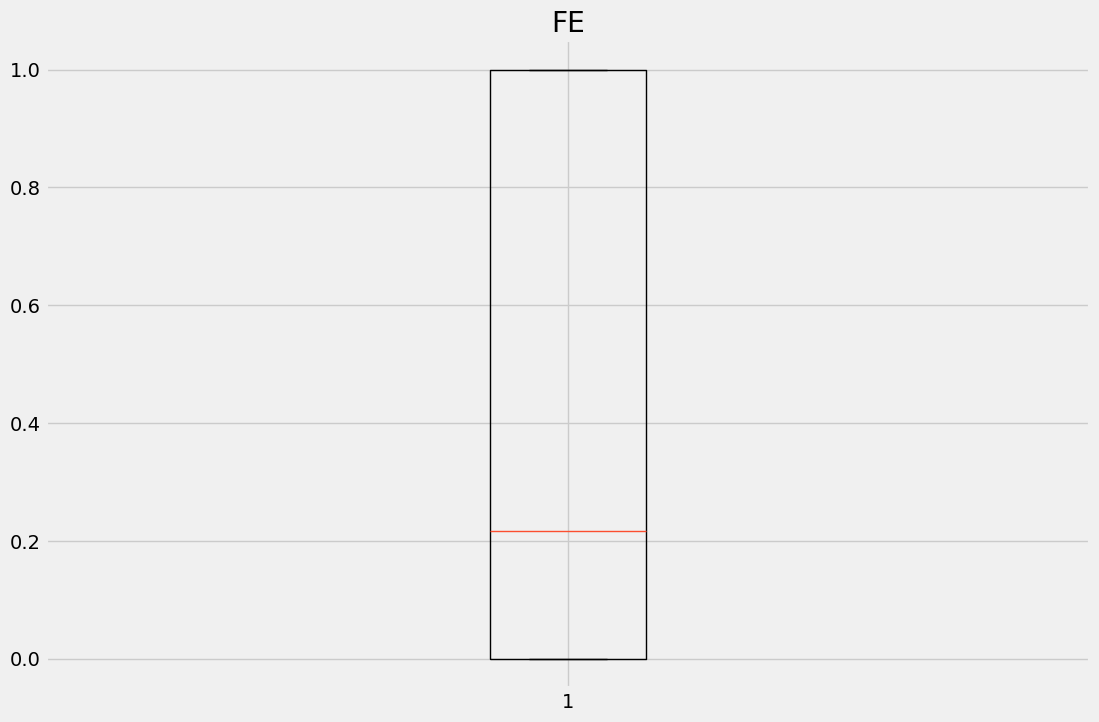

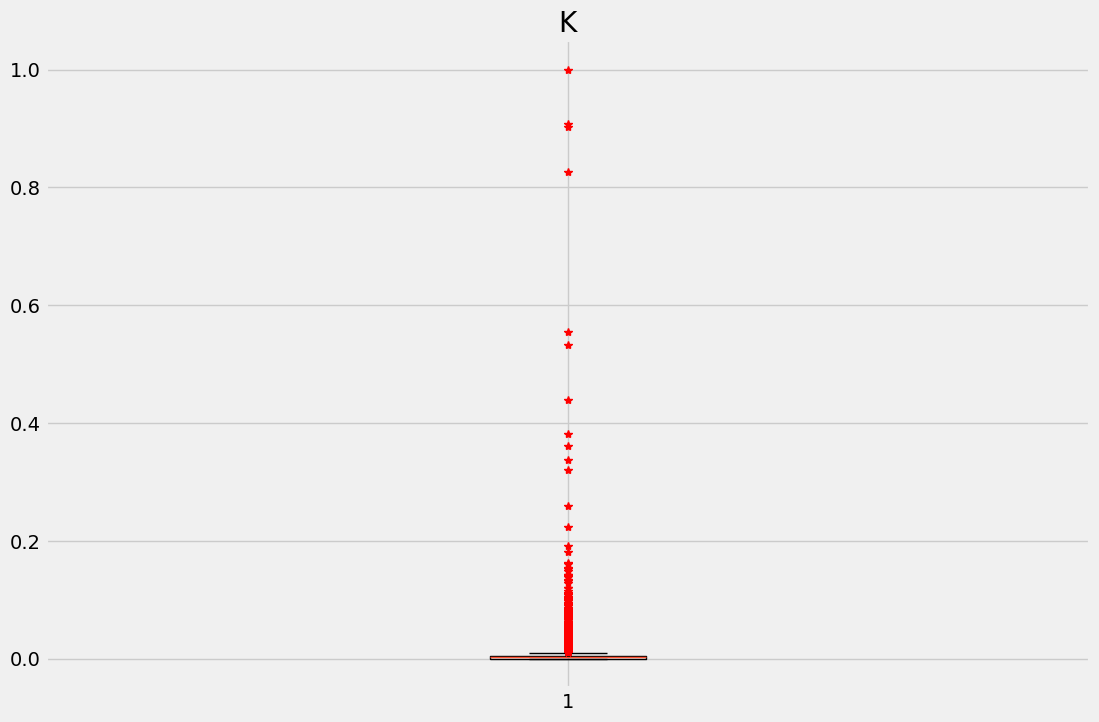

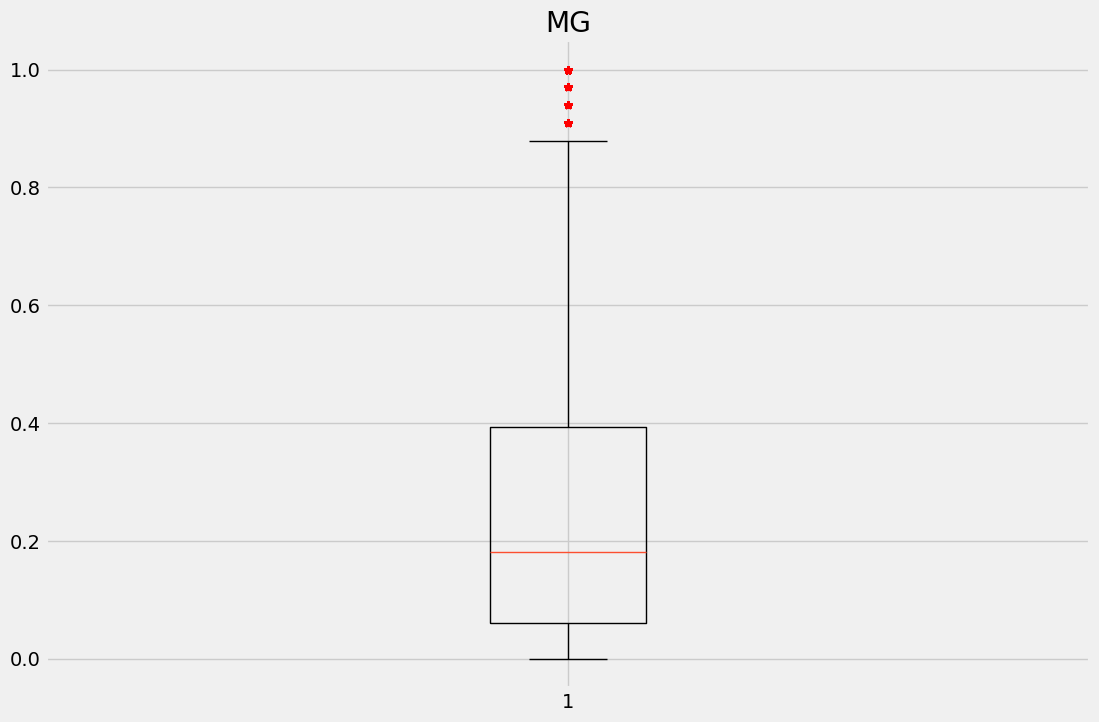

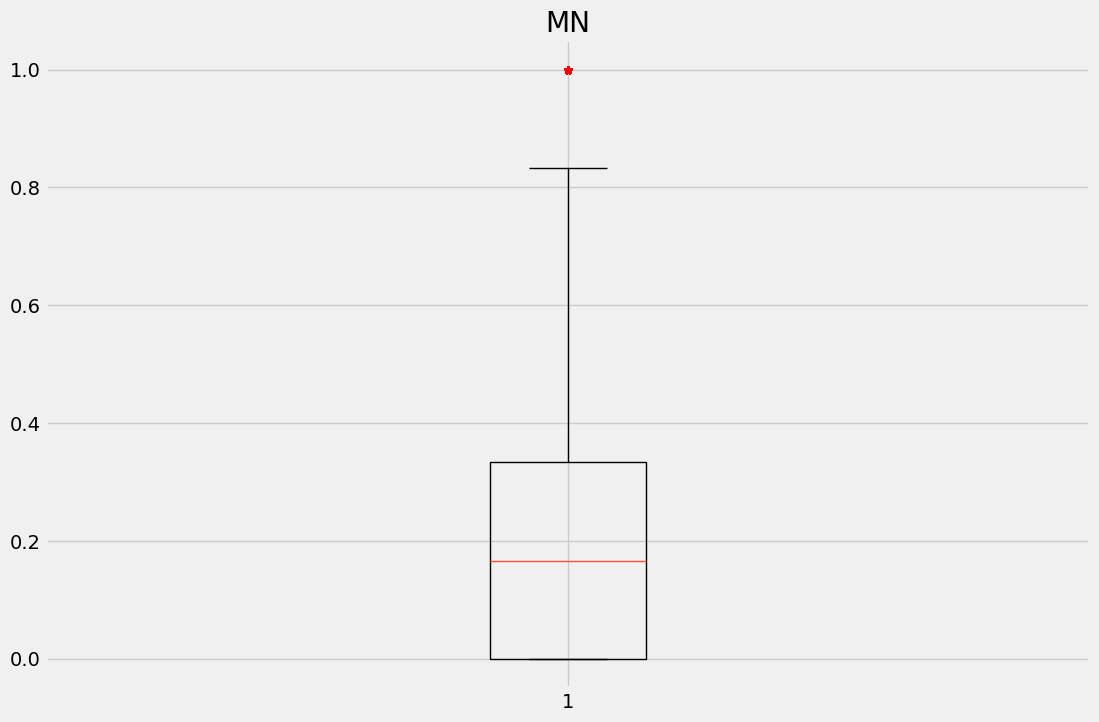

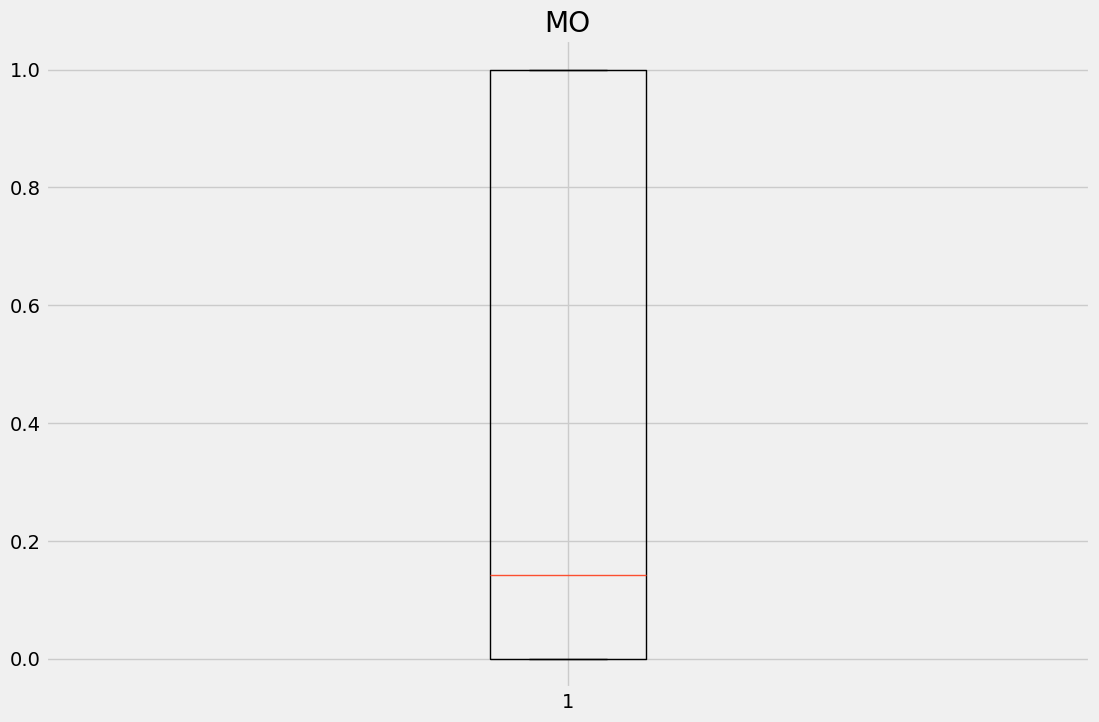

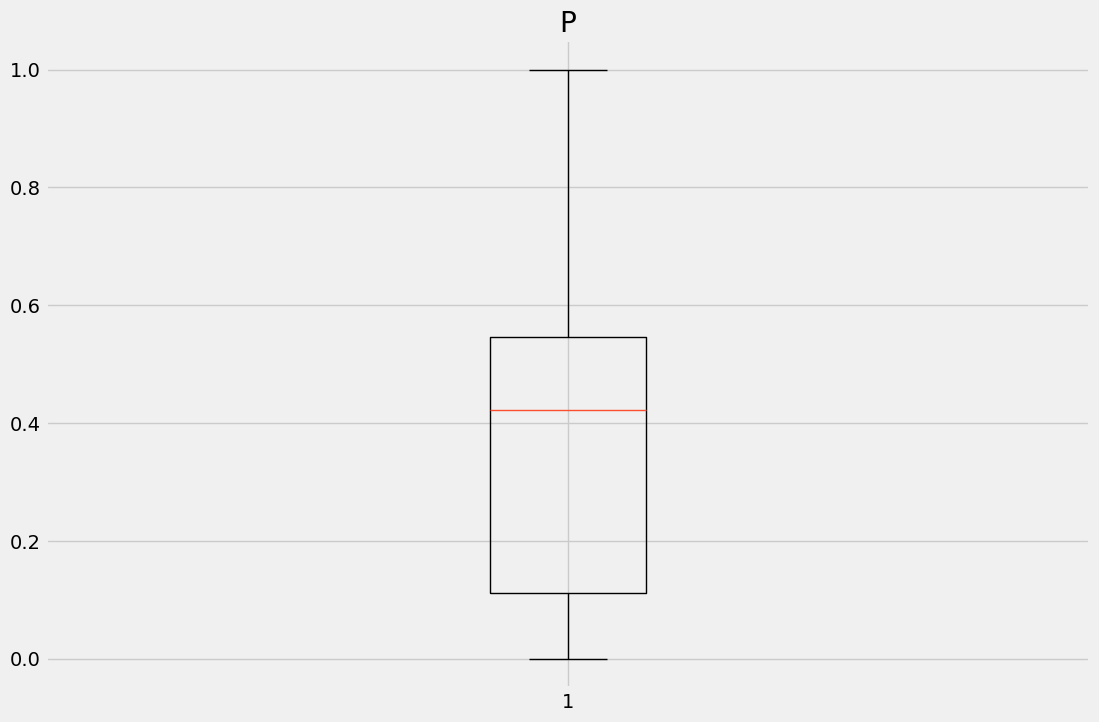

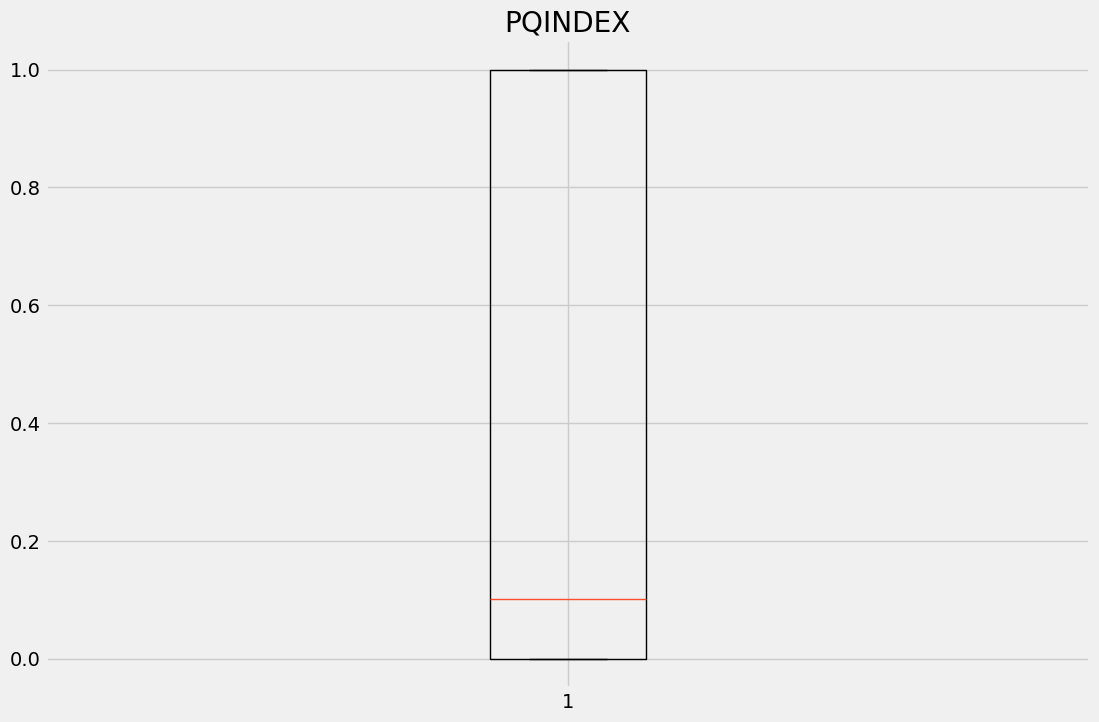

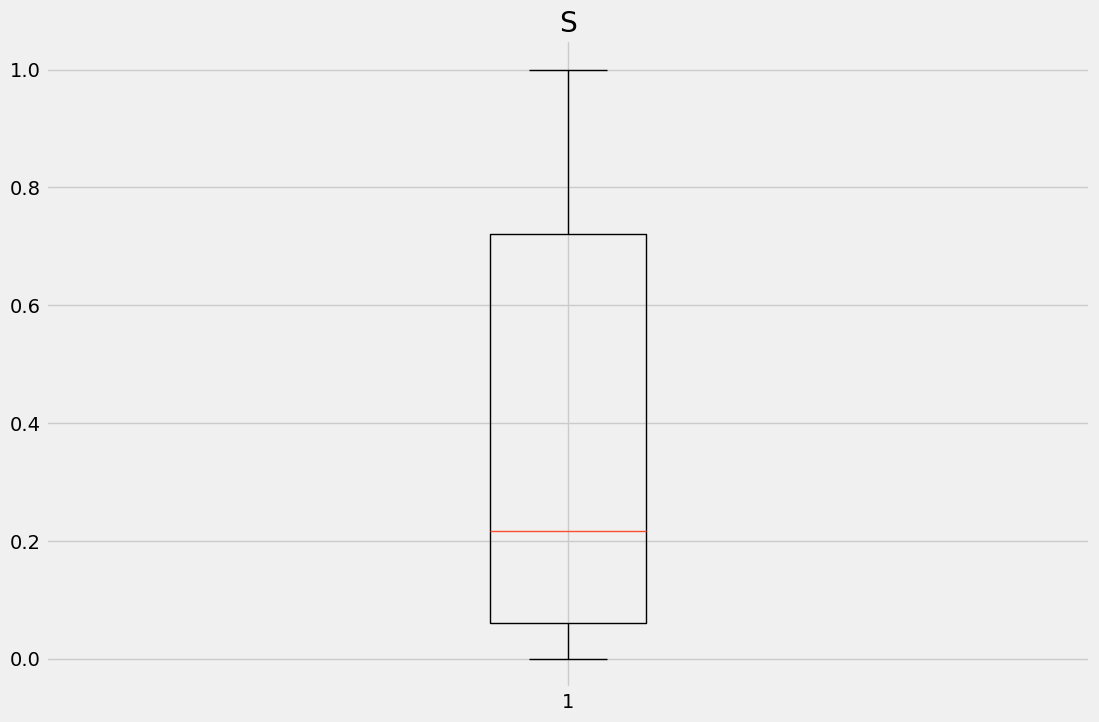

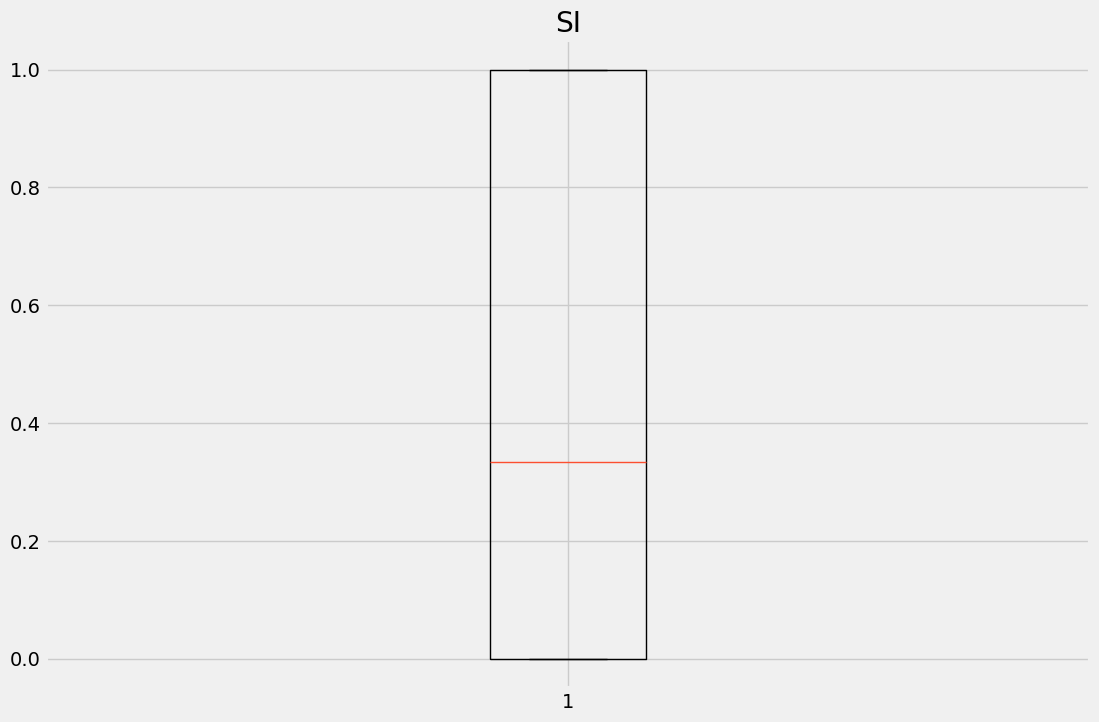

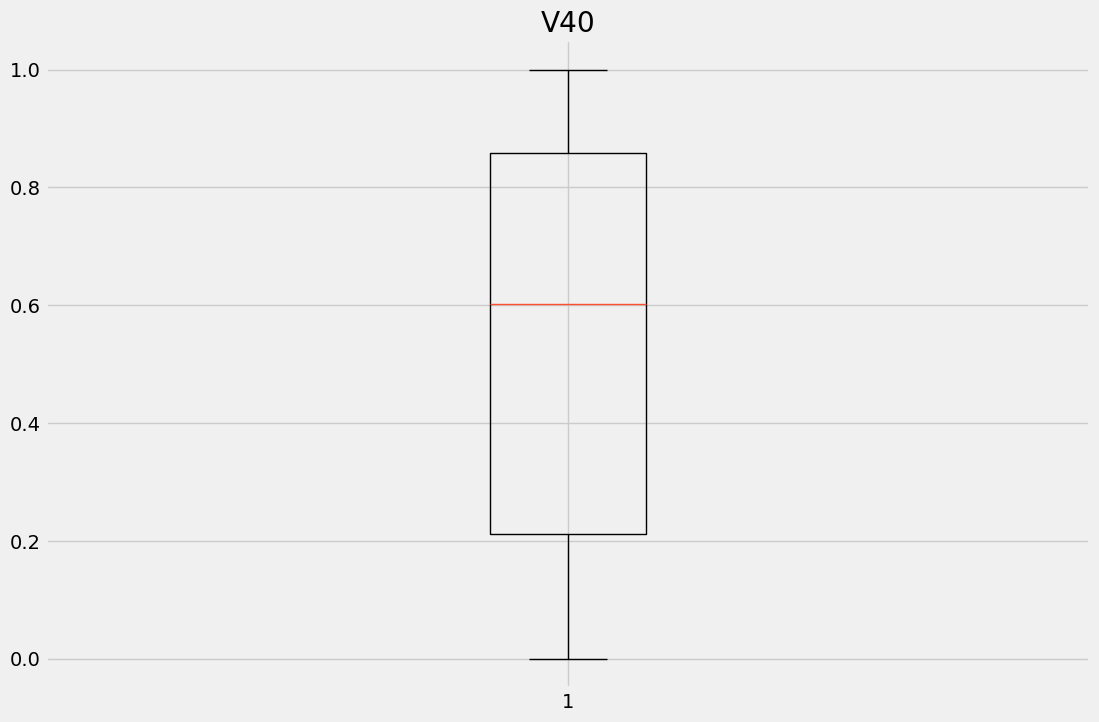

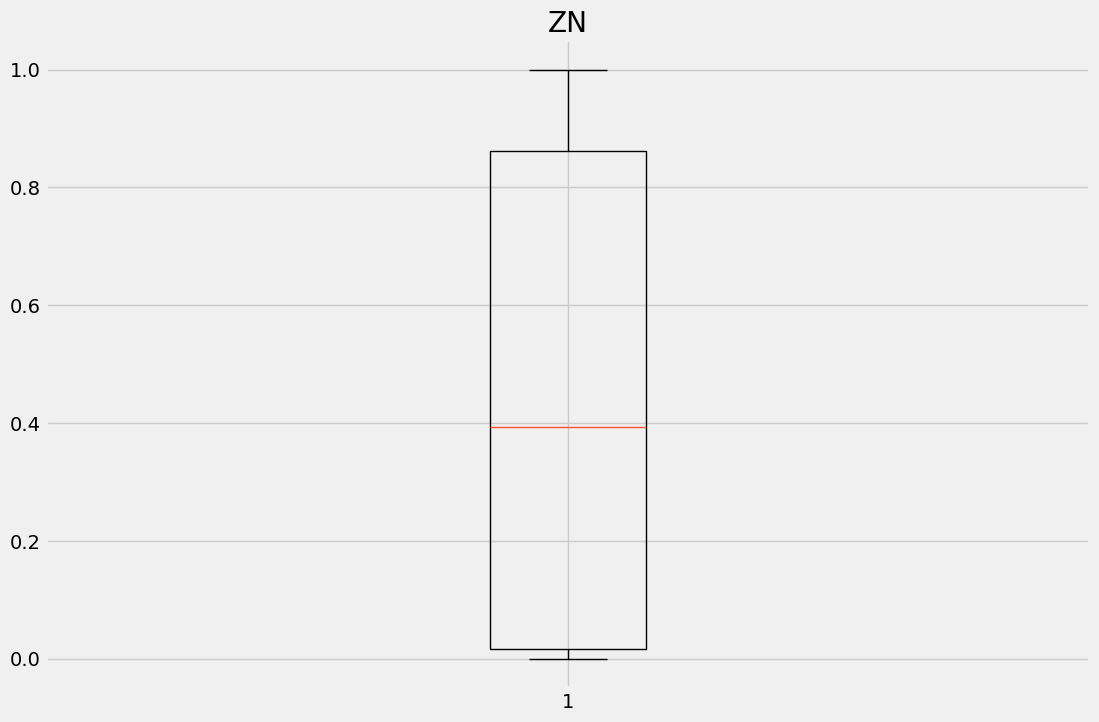

In [15]:
for col in numerical_features :
    plt.figure(figsize=(12, 8))
    plt.boxplot(train[col], sym='r*')
    plt.title(col)
    plt.show()

Except 'K' Feature

**Visualization numerical features - Test**

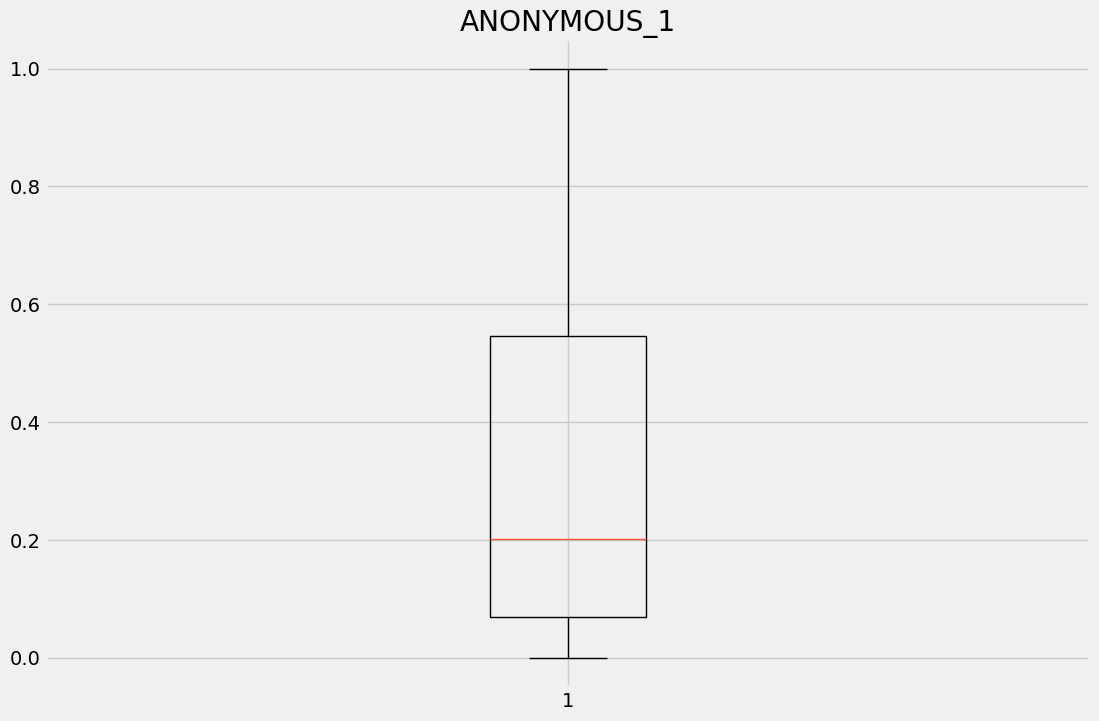

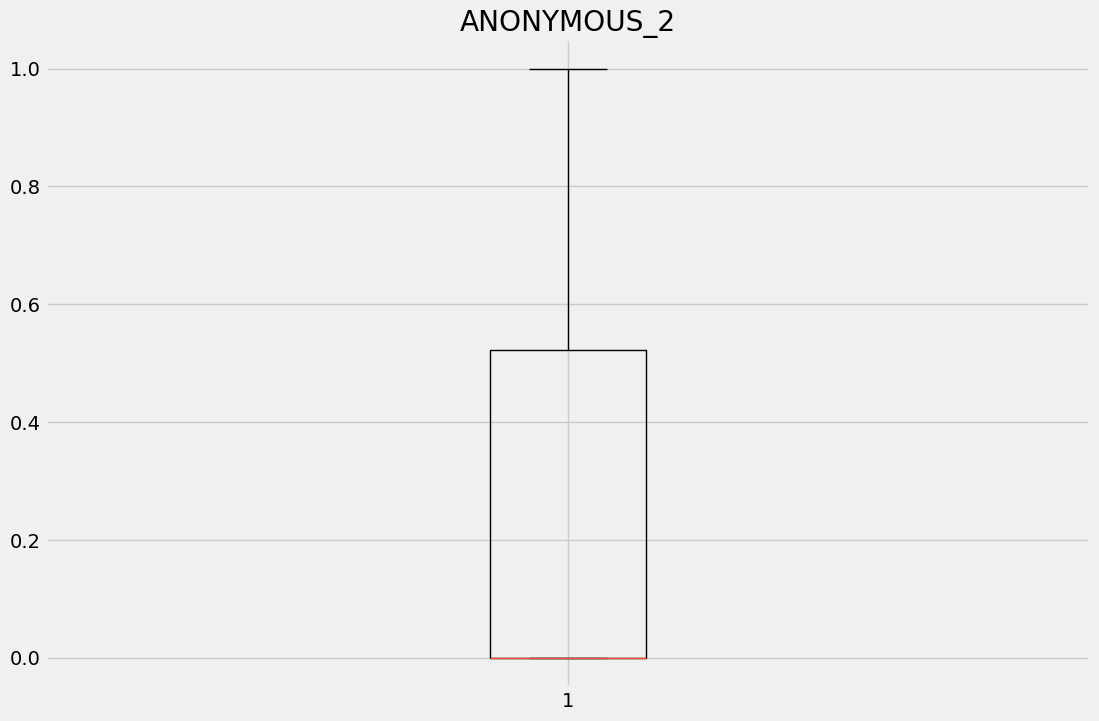

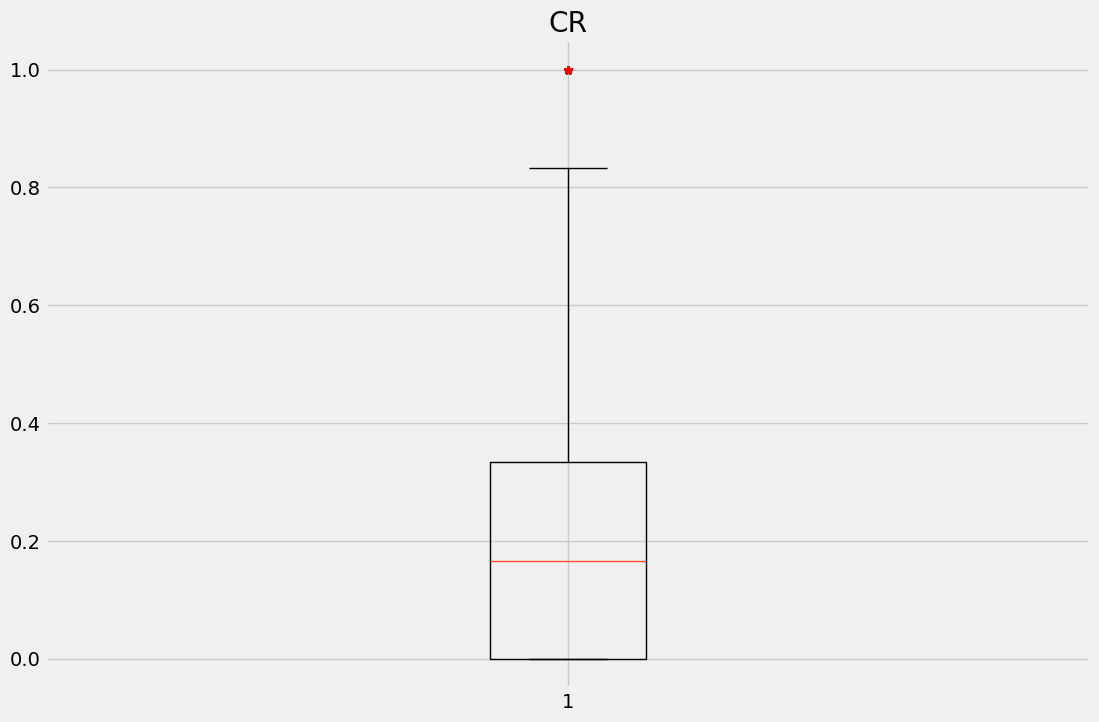

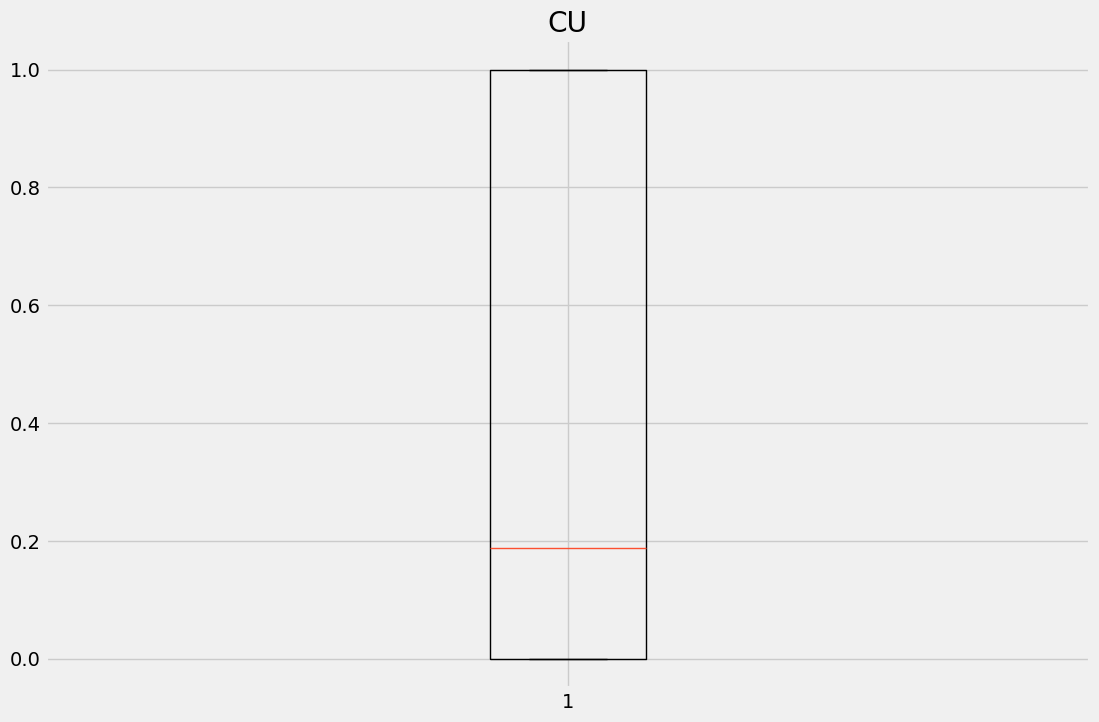

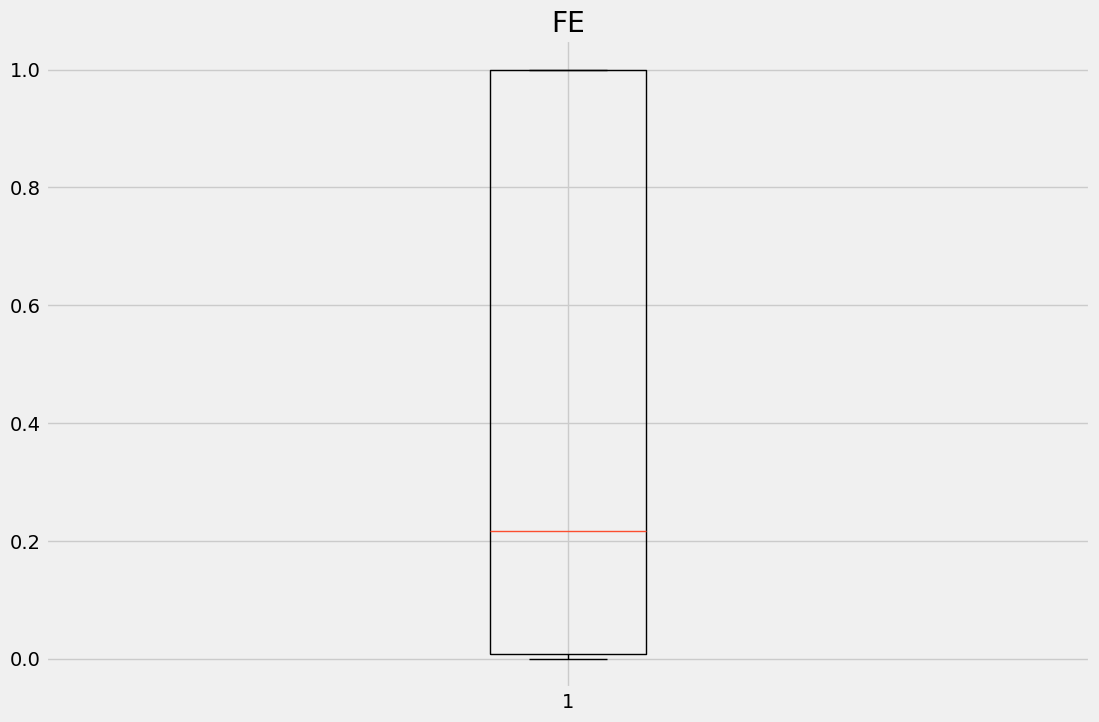

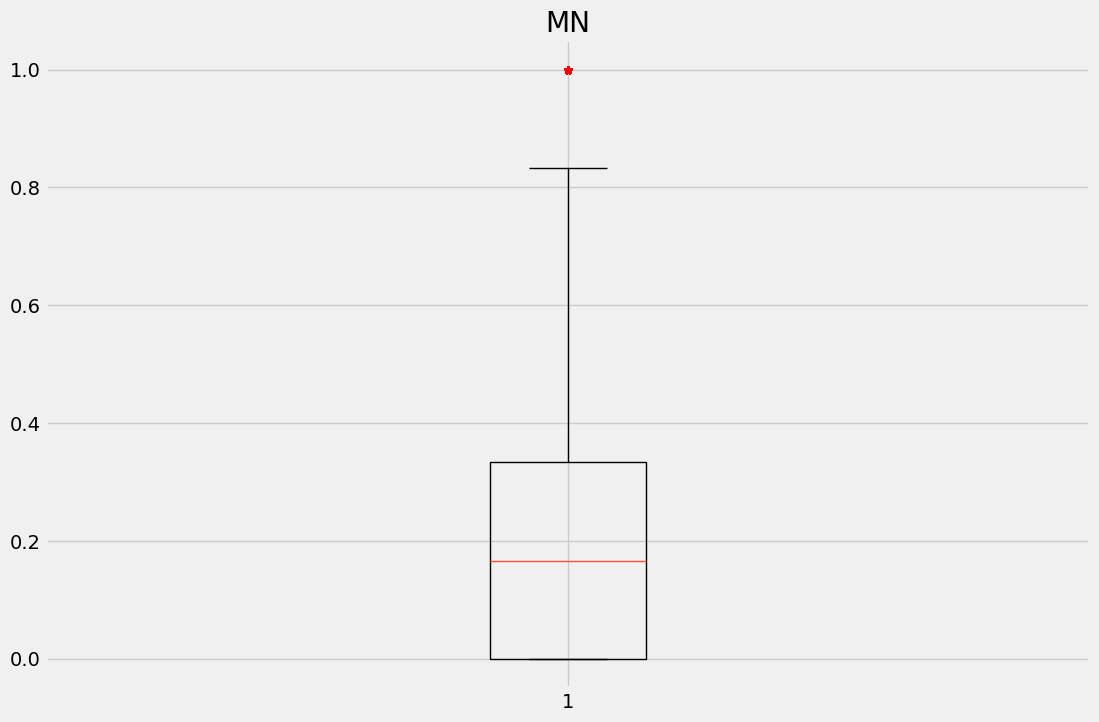

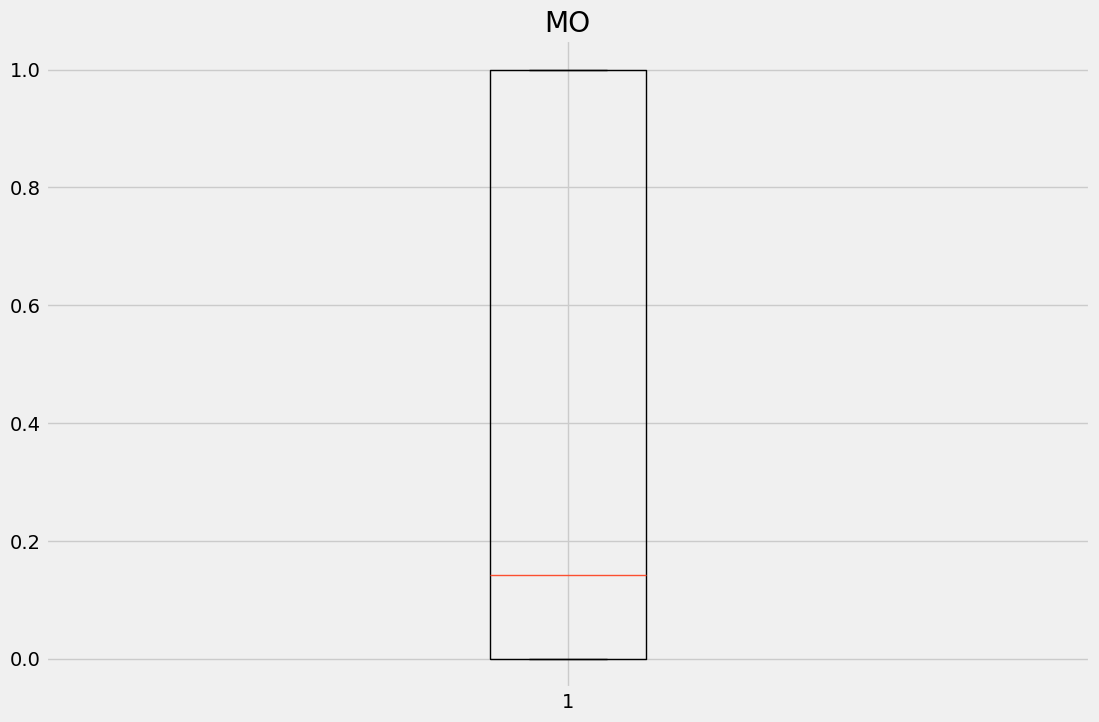

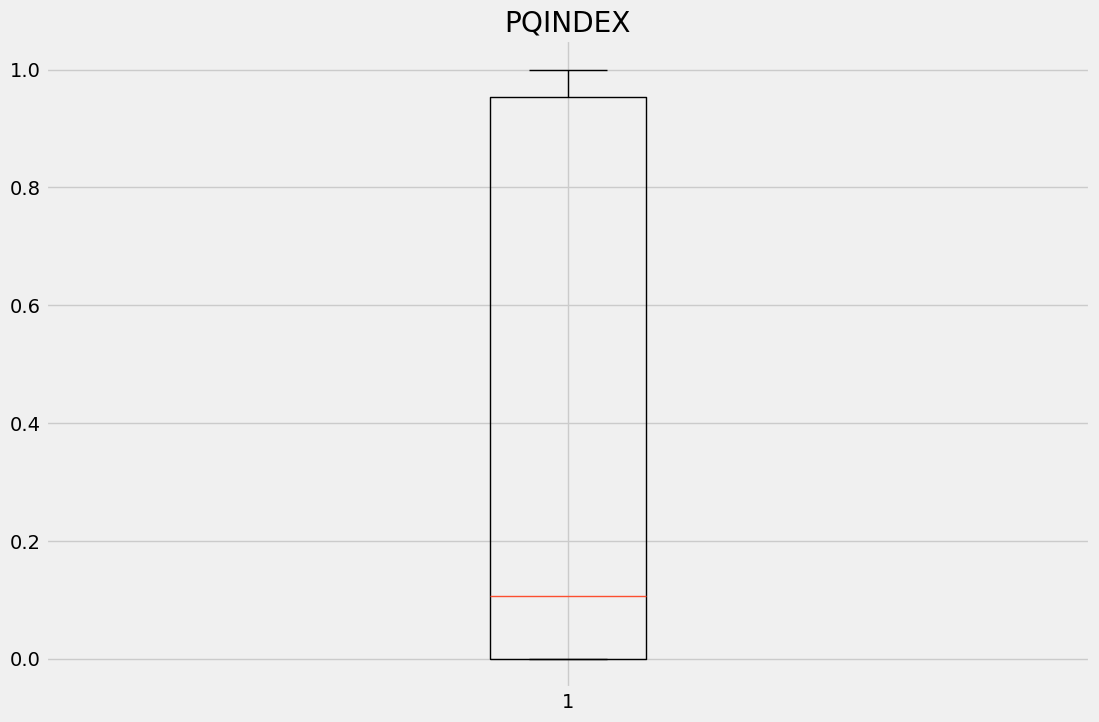

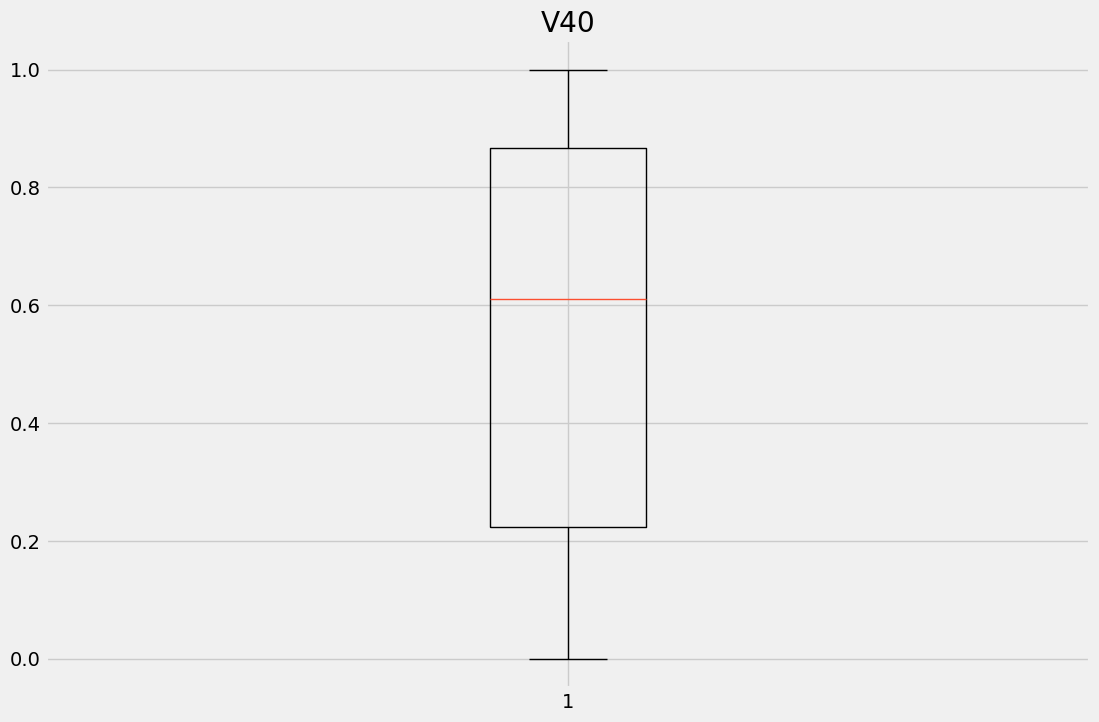

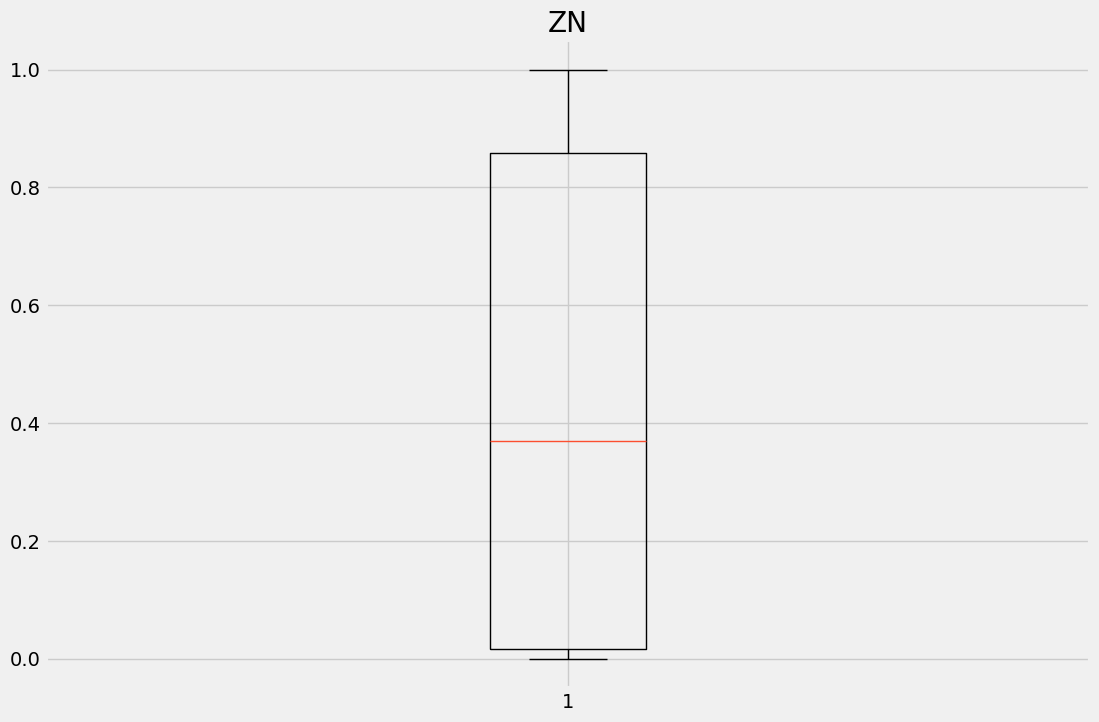

In [16]:
for col in test_numerical_features :
    plt.figure(figsize=(12, 8))
    plt.boxplot(test[col], sym='r*')
    plt.title(col)
    plt.show()

Except 'K' in Train Dataset

In [17]:
train = train.drop(['K'],axis=1)
train_info = train_info[~train_info['dataFeatures'].isin(['K'])]
train_info.reset_index(drop=True, inplace=True)

In [18]:
train_info

,dataFeatures,dataType,null,nullPCT,unique,minValue,maxValue,uniqueSample
0,ID,object,0,0.00,14095,TRAIN_00000,TRAIN_14094,"[TRAIN_00000, TRAIN_00001]"
1,COMPONENT_ARBITRARY,object,0,0.00,4,COMPONENT1,COMPONENT4,"[COMPONENT3, COMPONENT2]"
2,ANONYMOUS_1,int64,0,0.00,2951,1000,294451,"[1486, 1350]"
3,YEAR,int64,0,0.00,16,2007,2022,"[2011, 2021]"
4,SAMPLE_TRANSFER_DAY,int64,0,0.00,107,0,368,"[7, 51]"
5,ANONYMOUS_2,int64,0,0.00,842,200,9650,"[200, 375]"
6,AG,int64,0,0.00,4,0,3,"[0, 1]"
7,AL,int64,0,0.00,328,0,4630,"[3, 2]"
8,B,int64,0,0.00,504,0,2051,"[93, 19]"
9,BA,int64,0,0.00,38,0,216,"[0, 1]"


**Category Value**

**Nan -> Most of category Value**

In [19]:
train_info[train_info['nullPCT'] > 0]

,dataFeatures,dataType,null,nullPCT,unique,minValue,maxValue,uniqueSample
12,CD,float64,1394,9.89,6,0.0,18.0,"[0.0, nan]"


In [20]:
train.loc[train['CD'].isnull(), 'CD'] = train['CD'].value_counts().index[0]

**Check Categorical Value**

In [21]:
categorical_features = list(set(categorical_features) - {'ID', 'Y_LABEL'})

In [22]:
print('Categorical Value')
for col in categorical_features :
    print('-'*30)
    print('Feature: {}'.format(col))
    print('Value/Percentage')
    for i in train[col].value_counts().index.to_list():
        print('{}/{:.3f}'.format(i, (train[col].value_counts()[i]/train.shape[0])), end='  ')
        
    print('\n\n')

Categorical Value
------------------------------
Feature: NA
Value/Percentage
0/0.283  2/0.174  3/0.127  1/0.120  4/0.085  5/0.050  6/0.033  7/0.021  8/0.016  9/0.012  10/0.008  11/0.006  13/0.006  15/0.006  14/0.005  12/0.005  18/0.005  16/0.005  17/0.003  19/0.003  23/0.003  22/0.003  21/0.002  20/0.002  24/0.002  25/0.002  26/0.002  28/0.001  27/0.001  30/0.001  29/0.000  33/0.000  34/0.000  31/0.000  32/0.000  35/0.000  40/0.000  48/0.000  37/0.000  36/0.000  42/0.000  38/0.000  45/0.000  46/0.000  150/0.000  43/0.000  112/0.000  67/0.000  52/0.000  116/0.000  285/0.000  72/0.000  184/0.000  85/0.000  65/0.000  49/0.000  1212/0.000  70/0.000  53/0.000  60/0.000  177/0.000  62/0.000  1019/0.000  636/0.000  98/0.000  105/0.000  75/0.000  444/0.000  385/0.000  255/0.000  107/0.000  395/0.000  474/0.000  56/0.000  41/0.000  79/0.000  242/0.000  99/0.000  97/0.000  39/0.000  47/0.000  55/0.000  332/0.000  


------------------------------
Feature: CD
Value/Percentage
0.0/0.989  1.0/0.01

Except Columns: [BE, H2O, CD, LI, CO, AG, TI]

In [23]:
except_list = ['BE', 'H2O', 'CD', 'LI', 'CO', 'AG', 'TI']
train = train.loc[:, ~train.columns.isin(except_list)]
test = test.loc[:, ~test.columns.isin(except_list)]
categorical_features = list(set(categorical_features) - set(except_list))

In [24]:
print('Categorical Value')
for col in categorical_features :
    print('-'*30)
    print('Feature: {}'.format(col))
    print('Value/Percentage')
    for i in train[col].value_counts().index.to_list():
        print('{}/{:.3f}'.format(i, (train[col].value_counts()[i]/train.shape[0])), end='  ')
        
    print('\n\n')

Categorical Value
------------------------------
Feature: NA
Value/Percentage
0/0.283  2/0.174  3/0.127  1/0.120  4/0.085  5/0.050  6/0.033  7/0.021  8/0.016  9/0.012  10/0.008  11/0.006  13/0.006  15/0.006  14/0.005  12/0.005  18/0.005  16/0.005  17/0.003  19/0.003  23/0.003  22/0.003  21/0.002  20/0.002  24/0.002  25/0.002  26/0.002  28/0.001  27/0.001  30/0.001  29/0.000  33/0.000  34/0.000  31/0.000  32/0.000  35/0.000  40/0.000  48/0.000  37/0.000  36/0.000  42/0.000  38/0.000  45/0.000  46/0.000  150/0.000  43/0.000  112/0.000  67/0.000  52/0.000  116/0.000  285/0.000  72/0.000  184/0.000  85/0.000  65/0.000  49/0.000  1212/0.000  70/0.000  53/0.000  60/0.000  177/0.000  62/0.000  1019/0.000  636/0.000  98/0.000  105/0.000  75/0.000  444/0.000  385/0.000  255/0.000  107/0.000  395/0.000  474/0.000  56/0.000  41/0.000  79/0.000  242/0.000  99/0.000  97/0.000  39/0.000  47/0.000  55/0.000  332/0.000  


------------------------------
Feature: SN
Value/Percentage
0/0.709  1/0.127  2

In [25]:
numerical_categorical_features = list(set(categorical_features) - {'COMPONENT_ARBITRARY', 'YEAR'})

**COMPONENT_ARBITRARY**

In [26]:
enc.fit(train['COMPONENT_ARBITRARY'].values.reshape(-1, 1))
train['COMPONENT_ARBITRARY'] = enc.transform(train['COMPONENT_ARBITRARY'].values.reshape(-1, 1))
test['COMPONENT_ARBITRARY'] = enc.transform(test['COMPONENT_ARBITRARY'].values.reshape(-1, 1))

enc.fit(train['YEAR'].values.reshape(-1, 1))
train['YEAR'] = enc.transform(train['YEAR'].values.reshape(-1, 1))
test['YEAR'] = enc.transform(test['YEAR'].values.reshape(-1, 1))

**Ohter features**

In [27]:
threshold_list = [8, 5, 12, 12, 5, 17, 10]
for i,c in enumerate(numerical_categorical_features):
    train[c] = train[c].apply(lambda x: x if x <= threshold_list[i] else threshold_list[i])
    
    enc.fit(train[c].values.reshape(-1, 1))
    train[c] = enc.transform(train[c].values.reshape(-1, 1))
    
    if c in test.columns.to_list():
        test[c] = test[c].apply(lambda x: x if x <= threshold_list[i] else threshold_list[i])
        test[c] = enc.transform(test[c].values.reshape(-1, 1))

In [28]:
print('Categorical Value')
for col in categorical_features :
    print('-'*30)
    print('Feature: {}'.format(col))
    print('Value/Percentage')
    for i in train[col].value_counts().index.to_list():
        print('{}/{:.3f}'.format(i, (train[col].value_counts()[i]/train.shape[0])), end='  ')
        
    print('\n\n')

Categorical Value
------------------------------
Feature: NA
Value/Percentage
0.0/0.283  2.0/0.174  3.0/0.127  1.0/0.120  8.0/0.106  4.0/0.085  5.0/0.050  6.0/0.033  7.0/0.021  


------------------------------
Feature: SN
Value/Percentage
0.0/0.709  1.0/0.127  2.0/0.071  5.0/0.044  3.0/0.033  4.0/0.016  


------------------------------
Feature: V
Value/Percentage
0.0/0.972  1.0/0.020  2.0/0.005  3.0/0.001  4.0/0.001  9.0/0.001  5.0/0.000  6.0/0.000  7.0/0.000  8.0/0.000  


------------------------------
Feature: YEAR
Value/Percentage
1.0/0.101  7.0/0.099  6.0/0.084  8.0/0.082  4.0/0.081  5.0/0.076  2.0/0.067  9.0/0.067  10.0/0.064  11.0/0.062  3.0/0.061  12.0/0.046  14.0/0.034  13.0/0.026  15.0/0.025  0.0/0.023  


------------------------------
Feature: NI
Value/Percentage
0.0/0.782  1.0/0.113  2.0/0.042  3.0/0.019  4.0/0.011  12.0/0.010  5.0/0.006  6.0/0.006  7.0/0.003  8.0/0.002  9.0/0.002  11.0/0.002  10.0/0.001  


------------------------------
Feature: SB
Value/Percentage
0.0

**Check features after preprocessing**

In [29]:
common_columns = list(set(train.columns.to_list()) & set(test.columns.to_list()))

print('Train Columns: {}'.format(train.shape[1]))
print('Test Columns: {}'.format(test.shape[1]))
print('Common Columns: {}'.format(len(common_columns)))

Train Columns: 29
Test Columns: 15
Common Columns: 15


### Vislauzation Correlation

In [30]:
train_corr = train.copy()
train_corr = train_corr.astype({'Y_LABEL' : 'int'})
corr = train_corr.corr(method='pearson')

correlation = corr.unstack()
train_temp = pd.DataFrame(correlation['Y_LABEL'].sort_values(ascending=False), columns=['Y_LABEL'])
train_temp.style.background_gradient(cmap='viridis')

,Y_LABEL
Y_LABEL,1.000000
AL,0.371540
BA,0.180371
ANONYMOUS_1,0.089951
NI,0.065341
CR,0.051634
FE,0.047521
MN,0.042026
CU,0.030747
PQINDEX,0.030094


**Save result**

In [37]:
save_root_path = '/data/jyhwang/construction_machinery/Data/'

train.to_csv(os.path.join(save_root_path, 'preprocessing', 'train.csv'))
test.to_csv(os.path.join(save_root_path, 'preprocessing', 'test.csv'))

### Check Y Label

In [40]:
pre_train = pd.read_csv(os.path.join(save_root_path, 'preprocessing', 'train.csv'), index_col = 0)
pre_test = pd.read_csv(os.path.join(save_root_path, 'preprocessing', 'test.csv'), index_col = 0)

<AxesSubplot:ylabel='Y_LABEL'>

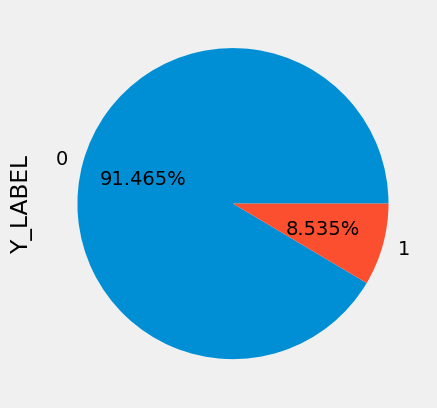

In [41]:
pre_train['Y_LABEL'].value_counts().plot(kind='pie', autopct='%.3f%%')

**Split Train & Validation**

In [53]:
data_index = pre_train.index.to_list()
data_y = pre_train['Y_LABEL'].to_list()

train_index, val_index, train_y, val_y = train_test_split(data_index, data_y, test_size=0.2, 
                                                          random_state=41, stratify=data_y)

train = pre_train.iloc[train_index, :].copy()
train.reset_index(drop=True, inplace=True)

validation = pre_train.iloc[val_index, :].copy()
validation.reset_index(drop=True, inplace=True)

<AxesSubplot:ylabel='Y_LABEL'>

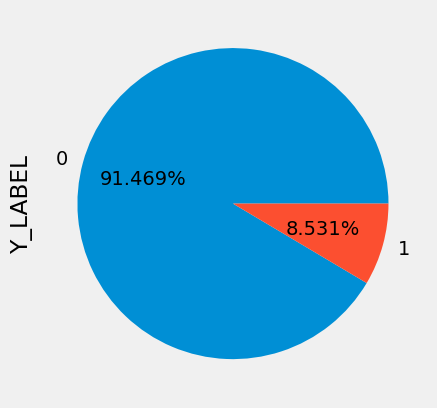

In [54]:
train.loc[:, 'Y_LABEL'].value_counts().plot(kind='pie', autopct='%.3f%%')

<AxesSubplot:ylabel='Y_LABEL'>

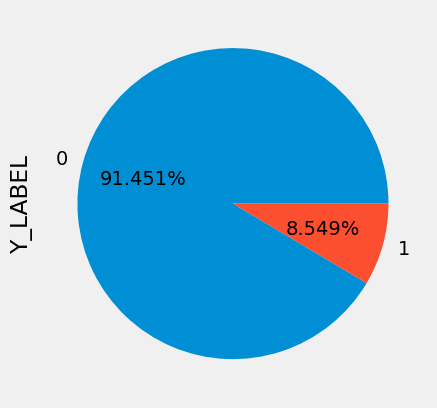

In [55]:
validation.loc[:, 'Y_LABEL'].value_counts().plot(kind='pie', autopct='%.3f%%')

**Save Train & Validation & Test**

In [110]:
# Train
train_x = train.iloc[:, 1:-1].values
train_y = train.iloc[:, -1].values
student_train_x = train.iloc[:, 1:-1].loc[:, student_index].values

with open(os.path.join(save_root_path, 'sampling', 'Train', 'no', 'x.npy'), 'wb') as f:
    np.save(f, train_x)
    
with open(os.path.join(save_root_path, 'sampling', 'Train', 'no', 's_x.npy'), 'wb') as f:
    np.save(f, student_train_x)
    
with open(os.path.join(save_root_path, 'sampling', 'Train', 'no', 'y.npy'), 'wb') as f:
    np.save(f, train_y)
    
# Validation
val_x = validation.iloc[:, 1:-1].values
val_y = validation.iloc[:, -1].values
student_val_x = validation.iloc[:, 1:-1].loc[:, student_index].values

with open(os.path.join(save_root_path, 'sampling', 'Validation', 'x.npy'), 'wb') as f:
    np.save(f, val_x)
    
with open(os.path.join(save_root_path, 'sampling', 'Validation', 's_x.npy'), 'wb') as f:
    np.save(f, student_val_x)
    
with open(os.path.join(save_root_path, 'sampling', 'Validation', 'y.npy'), 'wb') as f:
    np.save(f, val_y)

# Test
with open(os.path.join(save_root_path, 'sampling', 'Test', 'x.npy'), 'wb') as f:
    np.save(f, test.iloc[:, 1:].values)

**Oversampling**

In [113]:
train_over_x, train_over_y = over_sample.fit_resample(train_x, train_y)
student_train_over_x = train_over_x[:, student_index]

print('Label: 0: {}, 1: {}'.format(sum(train_over_y==0), sum(train_over_y==1)))

with open(os.path.join(save_root_path, 'sampling', 'Train', 'over', 'x.npy'), 'wb') as f:
    np.save(f, train_over_x)
    
with open(os.path.join(save_root_path, 'sampling', 'Train', 'over', 's_x.npy'), 'wb') as f:
    np.save(f, student_train_over_x)
    
with open(os.path.join(save_root_path, 'sampling', 'Train', 'over', 'y.npy'), 'wb') as f:
    np.save(f, train_over_y)

Label: 0: 10314, 1: 10314


**Undersampling**

In [111]:
train_under_x, train_under_y = under_sample.fit_resample(train_x, train_y)
student_train_under_x = train_under_x[:, student_index]

print('Label: 0: {}, 1: {}'.format(sum(train_under_y==0), sum(train_under_y==1)))

with open(os.path.join(save_root_path, 'sampling', 'Train', 'under', 'x.npy'), 'wb') as f:
    np.save(f, train_under_x)
    
with open(os.path.join(save_root_path, 'sampling', 'Train', 'under', 's_x.npy'), 'wb') as f:
    np.save(f, student_train_under_x)
    
with open(os.path.join(save_root_path, 'sampling', 'Train', 'under', 'y.npy'), 'wb') as f:
    np.save(f, train_under_y)

Label: 0: 962, 1: 962


### DataLoader

In [136]:
batch_index = 256

class CustomDataset(Dataset):
    def __init__(self, kind='train', sampling='no'):
        super(CustomDataset, self).__init__()
        data_root_path = '/data/jyhwang/construction_machinery/Data/sampling'
        
        if kind == 'train':
            data_root_path = os.path.join(data_root_path, 'Train', sampling)
        else:
            data_root_path = os.path.join(data_root_path, 'Validation')
            
        self.data_x = np.load(os.path.join(data_root_path, 'x.npy'))
        self.data_y = np.load(os.path.join(data_root_path, 'y.npy'))
        self.s_data_x = np.load(os.path.join(data_root_path, 's_x.npy'))
        
    def __len__(self):
        return len(self.data_x)
    
    def __getitem__(self, index):
        teacher_X = torch.Tensor(self.data_x[index])
        student_X = torch.Tensor(self.s_data_x[index])
        y = self.data_y[index]
        
        return teacher_X, student_X, y

### Check Train Dataset

**No Sampling**

In [132]:
train_dataset = CustomDataset(kind='train', sampling='no')
train_loader = DataLoader(train_dataset, batch_size = batch_index, shuffle=True)

for i, (x, s_x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
    if i == 0:
        print('X shape: {}, Student X shape: {}, Y: 0:{}, 1:{}'.format(x.shape, s_x.shape, sum(y==0), sum(y==1)))

  0%|          | 0/45 [00:00<?, ?it/s]

X shape: torch.Size([256, 27]), Train X shape: torch.Size([256, 14]), Y: 0:243, 1:13


**Oversampling**

In [138]:
train_dataset = CustomDataset(kind='train', sampling='over')
train_loader = DataLoader(train_dataset, batch_size = batch_index, shuffle=True)

for i, (x, s_x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
    if i == 0:
        print('X shape: {}, Student X shape: {}, Y: 0:{}, 1:{}'.format(x.shape, s_x.shape, sum(y==0), sum(y==1)))

  0%|          | 0/81 [00:00<?, ?it/s]

X shape: torch.Size([256, 27]), Student X shape: torch.Size([256, 14]), Y: 0:130, 1:126


In [134]:
train_dataset = CustomDataset(kind='train', sampling='under')
train_loader = DataLoader(train_dataset, batch_size = batch_index, shuffle=True)

for i, (x, s_x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
    if i == 0:
        print('X shape: {}, Student X shape: {}, Y: 0:{}, 1:{}'.format(x.shape, s_x.shape, sum(y==0), sum(y==1)))

  0%|          | 0/8 [00:00<?, ?it/s]

X shape: torch.Size([256, 27]), Train X shape: torch.Size([256, 14]), Y: 0:135, 1:121


**Validation**

In [140]:
val_dataset = CustomDataset(kind='val')
val_loader = DataLoader(val_dataset, batch_size = batch_index, shuffle=True)

for i, (x, s_x, y) in tqdm(enumerate(val_loader), total=len(val_loader)):
    if i == 0:
        print('X shape: {}, Student X shape: {}, Y: 0:{}, 1:{}'.format(x.shape, s_x.shape, sum(y==0), sum(y==1)))

  0%|          | 0/12 [00:00<?, ?it/s]

X shape: torch.Size([256, 27]), Student X shape: torch.Size([256, 14]), Y: 0:228, 1:28
